In [300]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [301]:
import re
import numpy as np

In [302]:
# df_trnsc = pd.read_csv("./sample_data/transactions-2020-07-01-2020-09-02 (1).csv")
df_trnsc = pd.read_csv("./sample_data/transactions-2020-05-11-2021-05-12.csv")
# 
df_trnsc.head(2)

/home/hadoop/anaconda3/envs/api/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Square Gift Card,Other Tender,Other Tender Type,Other Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Staff Name,Staff ID,Details,Description,Event Type,Location,Dining Option,Customer ID,Customer Name,Customer Reference ID,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
0,05/11/21,16:36:42,Mountain Time (US & Canada),$5.45,$0.00,$5.45,$0.00,$0.41,$1.00,$0.00,$6.86,Point of Sale,$6.86,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$-0.28,$6.58,nMOoMwZUNBD38dDpoWShe49eV,d64bXzvejDYRxOJDCfyGMXUJuaB,Visa,0244,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/nMOoMwZUNBD38dDpoWShe49eV/by-unit/7GW3QTHDACDY4,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,SONDER Coffee,NaN,A1RXPQDVKS6HH755X1J8V73C5M,Alondra Ibarra,NaN,NaN,NaN,NaN,NaN,2.6,$0.10,NaN,NaN,Complete,NaN
1,05/11/21,16:27:34,Mountain Time (US & Canada),$5.30,$0.00,$5.30,$0.00,$0.40,$0.00,$0.00,$5.70,Point of Sale,$0.00,NaN,$5.70,$0.00,$0.00,NaN,NaN,$0.00,$5.70,zO4ADRWqhbSBREyfYhMhJw4eV,LZodnqG5nV7PXjueyqU5KD97uaB,NaN,NaN,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/zO4ADRWqhbSBREyfYhMhJw4eV/by-unit/7GW3QTHDACDY4,"ROSE Latte (12oz HOT) - fragrant, floral, sweet & fun-- the ROSE latte.",Payment,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete,NaN


In [303]:
# note: later we will find "Event Type" and "Refund Reason" are also important
df_analysis = df_trnsc[["Date", "Time", "Time Zone", "Gross Sales", "Net Sales", "Total Collected", 
                        "Description",
                        "Event Type" , "Refund Reason",
                        "Source", "Card Entry Methods", "Location",
                        "Customer ID", "Customer Name"]]

In [304]:
# dropna,
# note: if Description is nan, there is almost nothing we can do. so drop Description==NAN
df_dropna = df_analysis[df_analysis.Description.notna()]
df_dropna.head()

,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name
0,05/11/21,16:36:42,Mountain Time (US & Canada),$5.45,$5.45,$6.86,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,A1RXPQDVKS6HH755X1J8V73C5M,Alondra Ibarra
1,05/11/21,16:27:34,Mountain Time (US & Canada),$5.30,$5.30,$5.70,"ROSE Latte (12oz HOT) - fragrant, floral, sweet & fun-- the ROSE latte.",Payment,NaN,Point of Sale,NaN,SONDER Coffee,NaN,NaN
2,05/11/21,16:26:19,Mountain Time (US & Canada),$3.80,$3.80,$5.08,Latte (8oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,CHCB4429S94AZFN47FHPXN969W,Shane Bischoff
3,05/11/21,16:15:10,Mountain Time (US & Canada),$5.20,$5.20,$5.59,"Chai Latte (16oz ICED) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai.",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,T1G6KED8EH2BH83B7CGJWCZEHW,(720) 415-4553
4,05/11/21,16:13:45,Mountain Time (US & Canada),$17.30,$17.30,$21.39,"Ritual Mexico (Regular), ORANGE Latte (12oz HOT) - sweet, fragrant, dreamsicle-like orange blossom latte.",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,J7Z6VRCNVD1PV3FRT82JHWQQFR,Cierra Mackanos


In [305]:
# ISSUE
# e.g., consider index 4991 and 6504
index_test = [4991, 6504]
df_dropna.loc[index_test,:][['Description']]
# 1. the seperator "," is mixed with product description
# 2. multiple same products are represented by ""[0-9] x" expression 
# note: 4991 includes exactely the same items (Toasted Coconut Latte) but it doesn't use 2 x symbol
# though this inconsistency would not affact the result (not using 2 x symbol is not a problem)

,Description
4991,"PISTACHIO Cold Brew (12OZ) - honey pistachio creamy cold brew\n\nserved with a splash of cream; please comment a substitute if you wish (almond, oat, coconut)"
6504,"Butter / Plain Croissant (Regular Price), 2 x Cappuccino (Regular Cappuccino) - double shot with four ounces of milk, slight foam and lower temperature and steamed for sweetness."


In [306]:
# use n-gram
import nltk
import unicodedata
import pandas as pd
import re

In [307]:
# html = "https://raw.githubusercontent.com/ecdedios/ngram-quick-start/master/tweets.csv"
# df = pd.read_csv( html,  error_bad_lines=False)
# # df.head()
# text = ''.join(str(df['text'].tolist()))
# text = (unicodedata.normalize('NFKD', text)
#     .encode('ascii', 'ignore')
#     .decode('utf-8', 'ignore')
#     .lower())
# words = re.sub(r'[^\w\s]', '', text).split()
# # words[:20]

# (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]

In [308]:
df_col_des = df_dropna.Description\
    .apply(lambda x: ",".join(("HEAD,"+x).split(",")))
df_col_des.head()


0                                                                          HEAD,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n
1                                                                                                    HEAD,ROSE Latte (12oz HOT) - fragrant, floral, sweet & fun-- the ROSE latte. 
2                                                                           HEAD,Latte (8oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n
3    HEAD,Chai Latte (16oz ICED) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai. 
4                                                                  HEAD,Ritual Mexico (Regular), ORANGE Latte (12oz HOT) - sweet, fragrant, dreamsicle-like orange blossom latte. 
Name: Description, dtype: object

In [309]:
# for now, neglect 2 x
text = ",".join(df_col_des.values.tolist())
words_list = [re.sub(r"[0-9]*[0-9] x ", "", e.replace("\n", "")\
#                      .replace("*", "\*")
                     .strip())\
              for e in text.split(",")]
words_list[:20]

['HEAD',
 'Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default',
 'HEAD',
 'ROSE Latte (12oz HOT) - fragrant',
 'floral',
 'sweet & fun-- the ROSE latte.',
 'HEAD',
 'Latte (8oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default',
 'HEAD',
 'Chai Latte (16oz ICED) - chai lattes using sanctuary chai tea concentrate. no sugar',
 'sweetened with honey. choose between the traditional',
 'spicy',
 'or decaf herbal chai.',
 'HEAD',
 'Ritual Mexico (Regular)',
 'ORANGE Latte (12oz HOT) - sweet',
 'fragrant',
 'dreamsicle-like orange blossom latte.',
 'HEAD',
 'Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default']

In [310]:
# using nltk to get 2-gram
df_ngram = pd.DataFrame(nltk.ngrams(words_list, 2))
df_ngram.columns = ["pred", "item"]
df_ngram.sort_values("item").head()


,pred,item
121239,Honey Pistachio Cold Brew (16OZ),'Stay Cozy' 16oz Mug (Regular)
53532,HEAD,'Stay Cozy' 16oz Mug (Regular)
52534,HEAD,'Stay Cozy' 16oz Mug (Regular)
52490,Guatemala | Finca La Union (Regular),'Stay Cozy' 16oz Mug (Regular)
46846,Embroidered Cap (Regular),'Stay Cozy' 16oz Mug (Regular)


In [311]:
# extract more features for the predecessors
df_item_pred = df_ngram.groupby("item").agg(reps=("pred", lambda x: x.count()),
                             # list_preds=("pred", lambda x: ",".join(x)),
                             unique_preds=("pred", lambda x: x.unique().tolist()),
                             contain_HEAD=("pred", lambda x: "HEAD" in x.unique().tolist()),
                             conut_unique_preds=("pred", lambda x: x.nunique())).reset_index()
df_item_pred.sort_values(["contain_HEAD", "reps"])

item  \
16                                                                                      Apple Orchard (Cider) (12oz hot)   
52   Black- China Breakfast (16oz ICED) - a full-bodied and smooth breakfast blend with hints of sweet caramel and spice   
73                                                                          Burma | Hornbill Chin (Regular) - Liza 11/22   
117                                                                                                Custom Amount - Gesha   
134                                                                Extra Shot (Regular) - Add an extra shot to any drink   
..                                                                                                                   ...   
91                                                Cappuccino (Regular Cappuccino) - double shot with four ounces of milk   
292                                      Nitro Coldbrew (16oz) - on tap nitro cold brew: creamy and chocolatey ethiopia.   
257          Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default   
252                      Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default   
261                     Latte (16oz ICED) - double espresso with milk // 16oz HOT lattes come with four shots by default   

     reps  \
16      1   
52      1   
73      1   
117     1   
134     1   
..    ...   
91   1628   
292  1736   
257  2699   
252  3644   
261  3663   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [312]:
print(df_item_pred[df_item_pred["contain_HEAD"]==False].sort_values("reps", ascending=False).count())
df_item_pred[df_item_pred.item!="HEAD"]\
[df_item_pred.conut_unique_preds>1][df_item_pred["contain_HEAD"]==False].sort_values("reps", ascending=True)


item                  113
reps                  113
unique_preds          113
contain_HEAD          113
conut_unique_preds    113
dtype: int64


<ipython-input-312-ccc42accf712>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_item_pred[df_item_pred.item!="HEAD"]\
<ipython-input-312-ccc42accf712>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_item_pred[df_item_pred.item!="HEAD"]\


,item,reps,unique_preds,contain_HEAD,conut_unique_preds
18,Apple Orchard (Cider) (16oz hot),2,"[Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default, and eight different fall spices // 16oz HOT lattes come with four shots by default]",False,2
107,Cold Brew,2,"[SONDER Embroidered Tees - L, SONDER Embroidered Tees - S]",False,2
385,Seasonal- Tangerine Ginger (12oz HOT) - a punchy hibiscus blend with zesty ginger,2,"[Americano (8oz HOT) - double espresso over water, Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default]",False,2
425,Sweet Jams (12oz) - Strawberry & black pepper creamy cold brew.,2,"[Quiche (Regular), Latte (16oz ICED) - double espresso with milk // 16oz LARGE lattes come with four shots by default]",False,2
354,Ritual Madagascar (Regular),3,"[Danish (Regular), Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz LARGE lattes come with four shots by default, Rose Cardamom Latte (16oz HOT) - seasonal housemade rose latte]",False,3
503,mango and mint.,4,"[Matcha Mango Mojito (12oz cold) - Matcha, Matcha Mango Mojito (16oz cold) - Matcha]",False,2
498,infusion and fresh floral notes of lilac and lily,6,"[Oolong- Bao Zhong (16oz ICED) - a lightly oxidized oolong with a clear green, Oolong- Bao Zhong (12oz HOT) - a lightly oxidized oolong with a clear green, Oolong- Bao Zhong (16oz HOT) - a lightly oxidized oolong with a clear green]",False,3
508,nectar-like infusion,8,"[Botanical- Rooibos (12oz HOT) - a naturally sweet and refreshing pure African rooibos with a deep red, Botanical- Rooibos (16oz ICED) - a naturally sweet and refreshing pure African rooibos with a deep red, Botanical- Rooibos (16oz HOT) - a naturally sweet and refreshing pure African rooibos with a deep red]",False,3
495,grassy high notes with a smooth body,11,"[Green- Sencha Superior (12oz HOT) - fresh, Green- Sencha Superior (16OZ HOT) - fresh]",False,2
478,citrus,13,"[Seasonal- Tangerine Ginger (16oz HOT) - a punchy hibiscus blend with zesty ginger, Seasonal- Tangerine Ginger (16oz ICED) - a punchy hibiscus blend with zesty ginger, Seasonal- Tangerine Ginger (12oz HOT) - a punchy hibiscus blend with zesty ginger]",False,3


# conclusion:
the only thing that is an "item" by itself but never appear as the HEAD are
- tip your barista
- free shipping,
- Sweet Jams (12 oz)

For now, save to just keep the items that ever have "HEAD" as predecessor. Later, we can fine tuned the item list if desired. (e.g., manually add Sweet Jams (12oz), see later)

In [313]:
df_item_real = df_item_pred[df_item_pred["contain_HEAD"]==True]

print(df_item_real.count())
df_item_real.sort_values("reps", ascending=False)

item                  432
reps                  432
unique_preds          432
contain_HEAD          432
conut_unique_preds    432
dtype: int64


item  \
261                      Latte (16oz ICED) - double espresso with milk // 16oz HOT lattes come with four shots by default   
252                       Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default   
257           Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default   
292                                       Nitro Coldbrew (16oz) - on tap nitro cold brew: creamy and chocolatey ethiopia.   
91                                                 Cappuccino (Regular Cappuccino) - double shot with four ounces of milk   
..                                                                                                                    ...   
184  Green- Houjicha (12oz HOT) - amber colored infusion with a smooth flavor and accents of chocolate and roasted barley   
89                                                                  COSTA RICA | Santa Rosa (Regular) - Felicity Markout!   
201                                                                           Guatemala | Finca La Union (Regular) - Liza   
321                                                                                       Orange Blossom Latte (16oz HOT)   
70                 Botanical- Rooibos (16oz ICED) - a naturally sweet and refreshing pure African rooibos with a deep red   

     reps  \
261  3663   
252  3644   
257  2699   
292  1736   
91   1628   
..    ...   
184     1   
89      1   
201     1   
321     1   
70      1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

/home/hadoop/anaconda3/envs/api/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='reps', ylabel='Density'>

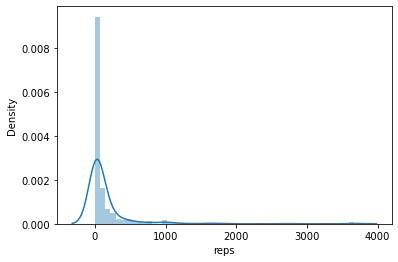

In [314]:
import seaborn as sns
sns.distplot(df_item_real.reps)

In [315]:
# note many items barely appear in the transaction, let's keep the items at least appear 10 times (for the past 1 year)
# df_item = df_item_real[df_item_real.reps>10][["item"]]
df_item = df_item_real[["item"]]

# manually add "Sweet Jams (12oz) - Strawberry & black pepper creamy cold brew."
item_add = ["Sweet Jams (12oz) - Strawberry & black pepper creamy cold brew."]
df_item = pd.concat([df_item, 
           pd.DataFrame(item_add, columns=["item"])], axis=0)\
            .sort_values("item").reset_index(drop=True)


print(df_item.count())
df_item.head(10)

item    433
dtype: int64


,item
0,'Stay Cozy' 16oz Mug (Regular)
1,*WILD GOOSE GUEST BAKERY* (4.75)
2,*WILD GOOSE GUEST BAKERY* (5)
3,12 Month Coffee Subscription Gift - 12 oz
4,3 Month Coffee Subscription Gift - 12 oz
5,Add Flavor or House Espresso (Regular)
6,Add Rotating Single Origin Espresso (Regular)
7,Aeropress (Regular)
8,Almond Croissant (Regular Price)
9,Americano (12oz HOT) - double espresso over water


In [316]:
# further extract info, like (12oz) HOT
df_item["item_header"] = df_item.item.apply(lambda x:  x.split(" - ")[0].strip())
df_item['name'] = df_item.item.apply(lambda x:  x.split("(")[0].strip())

# extract info
df_item["extra_info"] = df_item.item_header.apply(lambda x:  "".join(re.findall(r"\(.*\)", x)))
df_item["oz"] = df_item.item_header.apply(lambda x:  "".join(re.findall(r"[0-9]*[0-9]oz", x, flags=re.IGNORECASE)))
df_item["size"] = df_item.oz.apply(lambda x:  "".join(re.findall("[0-9]*[0-9]", x)))
df_item["temperature"] = df_item.item_header.apply(lambda x:  ""
                                                   .join([e.strip() for e in re.findall(" HOT| ICED", x, flags=re.IGNORECASE)]))

df_item

,item,item_header,name,extra_info,oz,size,temperature
0,'Stay Cozy' 16oz Mug (Regular),'Stay Cozy' 16oz Mug (Regular),'Stay Cozy' 16oz Mug,(Regular),16oz,16,
1,*WILD GOOSE GUEST BAKERY* (4.75),*WILD GOOSE GUEST BAKERY* (4.75),*WILD GOOSE GUEST BAKERY*,(4.75),,,
2,*WILD GOOSE GUEST BAKERY* (5),*WILD GOOSE GUEST BAKERY* (5),*WILD GOOSE GUEST BAKERY*,(5),,,
3,12 Month Coffee Subscription Gift - 12 oz,12 Month Coffee Subscription Gift,12 Month Coffee Subscription Gift - 12 oz,,,,
4,3 Month Coffee Subscription Gift - 12 oz,3 Month Coffee Subscription Gift,3 Month Coffee Subscription Gift - 12 oz,,,,
...,...,...,...,...,...,...,...
428,Winter Whiteout (Spiced-Maple Earl Grey) (12oz) - spiced maple shaken with iced on tap tea and cream // please specify to sub cream for oat,Winter Whiteout (Spiced-Maple Earl Grey) (12oz),Winter Whiteout,(Spiced-Maple Earl Grey) (12oz),12oz,12,
429,Winter Whiteout (Spiced-Maple Earl Grey) (16oz) - spiced maple shaken with iced on tap tea and cream // please specify to sub cream for oat,Winter Whiteout (Spiced-Maple Earl Grey) (16oz),Winter Whiteout,(Spiced-Maple Earl Grey) (16oz),16oz,16,
430,Yama Cold Brew (Single Origin) (12oz),Yama Cold Brew (Single Origin) (12oz),Yama Cold Brew,(Single Origin) (12oz),12oz,12,
431,Yama Cold Brew (Single Origin) (16oz),Yama Cold Brew (Single Origin) (16oz),Yama Cold Brew,(Single Origin) (16oz),16oz,16,


In [317]:
print(df_item.item.nunique(),
      df_item.item_header.nunique(),
      df_item.name.nunique())
      

433 330 169


In [318]:
df_test = df_item.groupby("item_header").count().sort_values("item", ascending=False)
df_test.head(20)

,item,name,extra_info,oz,size,temperature
item_header,,,,,,
COSTA RICA | Santa Rosa (Regular),4,4,4,4,4,4
COLOMBIA | Crucero (Regular),4,4,4,4,4,4
Batch Brew (16oz),3,3,3,3,3,3
Fireside Eve (Butterscotch-Whiskey Latte) (12oz iced),3,3,3,3,3,3
Fireside Eve (Butterscotch-Whiskey Latte) (12oz hot),3,3,3,3,3,3
Batch Brew (8oz),3,3,3,3,3,3
Fireside Eve (Butterscotch-Whiskey Latte) (16oz HOT ONLY),3,3,3,3,3,3
Fireside Eve (Butterscotch-Whiskey Latte) (16oz iced),3,3,3,3,3,3
Fireside Eve (Butterscotch-Whiskey Latte) (8oz hot),3,3,3,3,3,3


In [319]:
# note the following are essentially the same item, 
# so it is almost safe to just keep the item_header
df_item[df_item.item_header=="Nitro Coldbrew (16oz)"]

,item,item_header,name,extra_info,oz,size,temperature
275,Nitro Coldbrew (16oz) - on tap nitro cold brew: creamy and chocolatey ethiopia.,Nitro Coldbrew (16oz),Nitro Coldbrew,(16oz),16oz,16,
276,Nitro Coldbrew (16oz) - on tap nitro cold brew; a chocolate,Nitro Coldbrew (16oz),Nitro Coldbrew,(16oz),16oz,16,
277,Nitro Coldbrew (16oz) - on tap nitro cold brew; a chocolately,Nitro Coldbrew (16oz),Nitro Coldbrew,(16oz),16oz,16,


In [320]:
# while this is not true for the following
# but let's neglect the details like this.
# the name of the item need serious refactoring
df_item[df_item.item_header=="Espresso (Regular)"]

,item,item_header,name,extra_info,oz,size,temperature
121,Espresso (Regular) - double shot of our current single-origin espresso,Espresso (Regular),Espresso,(Regular),,,
122,"Espresso (Regular) - single-origin BURMA as ""double shot"" espresso",Espresso (Regular),Espresso,(Regular),,,
123,"Espresso (Regular) - single-origin Colombia ""double shot"" espresso.",Espresso (Regular),Espresso,(Regular),,,


In [321]:
df_item_inven = df_item.groupby("item_header").first().reset_index().drop("item", axis=1)
df_item_inven.head()

# It is still better to keep the item as a whole (maybe not)
# df_item_inven = df_item.copy()

,item_header,name,extra_info,oz,size,temperature
0,'Stay Cozy' 16oz Mug (Regular),'Stay Cozy' 16oz Mug,(Regular),16oz,16,
1,*WILD GOOSE GUEST BAKERY* (4.75),*WILD GOOSE GUEST BAKERY*,(4.75),,,
2,*WILD GOOSE GUEST BAKERY* (5),*WILD GOOSE GUEST BAKERY*,(5),,,
3,12 Month Coffee Subscription Gift,12 Month Coffee Subscription Gift - 12 oz,,,,
4,3 Month Coffee Subscription Gift,3 Month Coffee Subscription Gift - 12 oz,,,,


In [322]:
df_item_inven["item_id"] = df_item_inven.index.to_series().apply(lambda x: "#"+str(x).zfill(4)+"#")
df_item_inven.head()

,item_header,name,extra_info,oz,size,temperature,item_id
0,'Stay Cozy' 16oz Mug (Regular),'Stay Cozy' 16oz Mug,(Regular),16oz,16,,#0000#
1,*WILD GOOSE GUEST BAKERY* (4.75),*WILD GOOSE GUEST BAKERY*,(4.75),,,,#0001#
2,*WILD GOOSE GUEST BAKERY* (5),*WILD GOOSE GUEST BAKERY*,(5),,,,#0002#
3,12 Month Coffee Subscription Gift,12 Month Coffee Subscription Gift - 12 oz,,,,,#0003#
4,3 Month Coffee Subscription Gift,3 Month Coffee Subscription Gift - 12 oz,,,,,#0004#


In [323]:
# extract item_head
# carefully handle 2 x

# example1:
# input: 2 x Refill (Regular)
# output: [Refill (Regular),Refill (Regular)]
# example2:
# input: "Nitro Coldbrew (16oz) - on tap nitro cold brew; a chocolately, balanced and light house blend. , Hand Brew (Current Selection) - a featured single-origin coffee brewed on v60 by hand, 10oz."
# output: ['Nitro Coldbrew (16oz)', 'Hand Brew (Current Selection)']

def contained_substring(test_element, test_list):
    for substring in test_list:
        if substring in test_element:
            if (re.match(r"([0-9])*[0-9] x ", test_element)):
                return re.findall(r"[0-9]*[0-9] x ", test_element)[0]+substring
            else: return substring
    return None

def seperat_num_x_and_flaten(multi_item):
    flat_list = []
    for item in multi_item:
        if item is not None:         
            if (re.match(r"([0-9])*[0-9] x ", item)):
                num_x_item = [e.strip() for e in item.split(" x ")]
                flat_list = flat_list + [num_x_item[1]] * int(num_x_item[0])
            else:
                flat_list.append(item)
    return flat_list

test_list = df_item_inven.item_header.to_list()
test_row = "Nitro Coldbrew (16oz) - on tap nitro cold brew; a chocolately, balanced and light house blend. , Hand Brew (Current Selection) - a featured single-origin coffee brewed on v60 by hand, 10oz."
row_item_header = [contained_substring(e, test_list) for e in test_row.split(",")]
print(row_item_header)
print(seperat_num_x_and_flaten(row_item_header))
test_row = "2 x Refill (Regular)"
row_item_header = [contained_substring(e, test_list) for e in test_row.split(",")]
print(row_item_header)
print(seperat_num_x_and_flaten(row_item_header))

# this one has some problem
test_row = "ORANGE Latte (16oz ICED) - sweet, fragrant, dreamsicle-like orange blossom latte."
row_item_header = [contained_substring(e, test_list) for e in test_row.split(",")]
print(row_item_header)
print(seperat_num_x_and_flaten(row_item_header))

['Nitro Coldbrew (16oz)', None, 'Hand Brew (Current Selection)', None]
['Nitro Coldbrew (16oz)', 'Hand Brew (Current Selection)']
['2 x Refill (Regular)']
['Refill (Regular)', 'Refill (Regular)']
['Latte (16oz ICED)', None, None]
['Latte (16oz ICED)']


In [324]:
# greedy search
def find_longest_element(list_candidate):
    if list_candidate != []:
        return max(list_candidate, key=len)
    return None

def greedy_contained_substring(test_element, ref_list):
    candidate_list = []
    for substring in ref_list:
        if substring in test_element:
            if (re.match(r"([0-9])*[0-9] x ", test_element)):
                candidate_list.append(re.findall(r"[0-9]*[0-9] x ", test_element)[0]+substring)
            else: candidate_list.append(substring)

    return find_longest_element(candidate_list)



def seperat_num_x_and_flaten(multi_item):
    flat_list = []
    for item in multi_item:
        if item is not None:         
            if (re.match(r"([0-9])*[0-9] x ", item)):
                num_x_item = [e.strip() for e in item.split(" x ")]
                flat_list = flat_list + [num_x_item[1]] * int(num_x_item[0])
            else:
                flat_list.append(item)
    return flat_list

test_list = df_item_inven.item_header.to_list()

test_row = "2 x ORANGE Latte (16oz ICED) - sweet, fragrant, dreamsicle-like orange blossom latte."
row_item_header = [greedy_contained_substring(e, test_list) for e in test_row.split(",")]
print(row_item_header)


test_row = "ORANGE Latte (16oz ICED) - sweet, fragrant, dreamsicle-like orange blossom latte."
row_item_header = [greedy_contained_substring(e, test_list) for e in test_row.split(",")]
print(row_item_header)
print(seperat_num_x_and_flaten(row_item_header))

['2 x ORANGE Latte (16oz ICED)', None, None]
['ORANGE Latte (16oz ICED)', None, None]
['ORANGE Latte (16oz ICED)']


In [325]:
test_list = df_item_inven.item_header.to_list()

df_description = pd.DataFrame(df_dropna.Description\
    .apply(lambda x: x.split(",")))

df_description["items_list"] = df_description.Description\
    .apply(lambda x: seperat_num_x_and_flaten([greedy_contained_substring(e, test_list) for e in x]))
df_description.head(10)

,Description,items_list
0,[Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n],[Latte (12oz HOT)]
1,"[ROSE Latte (12oz HOT) - fragrant, floral, sweet & fun-- the ROSE latte. ]",[ROSE Latte (12oz HOT)]
2,[Latte (8oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n],[Latte (8oz HOT)]
3,"[Chai Latte (16oz ICED) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai. ]",[Chai Latte (16oz ICED)]
4,"[Ritual Mexico (Regular), ORANGE Latte (12oz HOT) - sweet, fragrant, dreamsicle-like orange blossom latte. ]","[Ritual Mexico (Regular), ORANGE Latte (12oz HOT)]"
5,[Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default \n],[Latte (16oz HOT (quad shot))]
6,[2 x Refill (Regular)],"[Refill (Regular), Refill (Regular)]"
7,"[Nitro Coldbrew (16oz) - on tap nitro cold brew; a chocolately, balanced and light house blend. , Hand Brew (Current Selection) - a featured single-origin coffee brewed on v60 by hand, 10oz.]","[Nitro Coldbrew (16oz), Hand Brew (Current Selection)]"
8,"[ORANGE Latte (16oz ICED) - sweet, fragrant, dreamsicle-like orange blossom latte. ]",[ORANGE Latte (16oz ICED)]
9,[KIWI Matcha (16OZ) - kiwi inspired matcha & chia mocktail],[KIWI Matcha (16OZ)]


In [326]:
# mapping based on dict
# map item => item_id and/or price 
def row_items_mapping(row, dict_map):
    return [dict_map.get(e) for e in row]

dict_map = dict()
for key_value in df_item_inven[["item_header", "item_id"]].values:
    dict_map[key_value[0]] = key_value[1]
dict_map

# df_dict_map_name_item_id = df_item_inven[["item_header", "item_id"]]
# df_dict_map_name_item_id
df_description.items_list.apply(lambda x: row_items_mapping(x, dict_map))


0                [#0180#]
1                [#0235#]
2                [#0185#]
3                [#0062#]
4        [#0251#, #0208#]
               ...       
39053            [#0085#]
39054            [#0147#]
39055    [#0165#, #0058#]
39056            [#0066#]
39057            [#0281#]
Name: items_list, Length: 39027, dtype: object

In [327]:
# get back to the drop_na: mapping item_id, item_name to the transaction df
df_dropna_new = df_dropna.copy()
df_dropna_new["item_lists"] = df_description.items_list
df_dropna_new["item_ids"] = df_description.items_list.apply(lambda x: row_items_mapping(x, dict_map))
df_dropna_new["item_counts"] = df_dropna_new.item_ids.apply(lambda x: len(x))
df_dropna_new.head()

,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts
0,05/11/21,16:36:42,Mountain Time (US & Canada),$5.45,$5.45,$6.86,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,A1RXPQDVKS6HH755X1J8V73C5M,Alondra Ibarra,[Latte (12oz HOT)],[#0180#],1
1,05/11/21,16:27:34,Mountain Time (US & Canada),$5.30,$5.30,$5.70,"ROSE Latte (12oz HOT) - fragrant, floral, sweet & fun-- the ROSE latte.",Payment,NaN,Point of Sale,NaN,SONDER Coffee,NaN,NaN,[ROSE Latte (12oz HOT)],[#0235#],1
2,05/11/21,16:26:19,Mountain Time (US & Canada),$3.80,$3.80,$5.08,Latte (8oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,CHCB4429S94AZFN47FHPXN969W,Shane Bischoff,[Latte (8oz HOT)],[#0185#],1
3,05/11/21,16:15:10,Mountain Time (US & Canada),$5.20,$5.20,$5.59,"Chai Latte (16oz ICED) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai.",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,T1G6KED8EH2BH83B7CGJWCZEHW,(720) 415-4553,[Chai Latte (16oz ICED)],[#0062#],1
4,05/11/21,16:13:45,Mountain Time (US & Canada),$17.30,$17.30,$21.39,"Ritual Mexico (Regular), ORANGE Latte (12oz HOT) - sweet, fragrant, dreamsicle-like orange blossom latte.",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,J7Z6VRCNVD1PV3FRT82JHWQQFR,Cierra Mackanos,"[Ritual Mexico (Regular), ORANGE Latte (12oz HOT)]","[#0251#, #0208#]",2


In [328]:
# pd.merge(left = df_item_inven, right= df_dropna_new[df_dropna_new.item_counts==1])
df_only_one = df_dropna_new[df_dropna_new.item_counts==1]
df_only_one["price_gross"] = df_only_one["Gross Sales"].apply(lambda x: float(x.strip()[1:]))
# df_only_one["price_net"] = df_only_one["Net Sales"].apply(lambda x: float(x.strip().split("$")[-1]))
df_only_one["item_id"] = df_only_one["item_ids"].apply(lambda x: x[0])
df_only_one["item_name"] = df_only_one["item_lists"].apply(lambda x: x[0])

df_only_one.head()

<ipython-input-328-dcdd9219ffc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_one["price_gross"] = df_only_one["Gross Sales"].apply(lambda x: float(x.strip()[1:]))
<ipython-input-328-dcdd9219ffc4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_one["item_id"] = df_only_one["item_ids"].apply(lambda x: x[0])
<ipython-input-328-dcdd9219ffc4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts,price_gross,item_id,item_name
0,05/11/21,16:36:42,Mountain Time (US & Canada),$5.45,$5.45,$6.86,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,A1RXPQDVKS6HH755X1J8V73C5M,Alondra Ibarra,[Latte (12oz HOT)],[#0180#],1,5.45,#0180#,Latte (12oz HOT)
1,05/11/21,16:27:34,Mountain Time (US & Canada),$5.30,$5.30,$5.70,"ROSE Latte (12oz HOT) - fragrant, floral, sweet & fun-- the ROSE latte.",Payment,NaN,Point of Sale,NaN,SONDER Coffee,NaN,NaN,[ROSE Latte (12oz HOT)],[#0235#],1,5.30,#0235#,ROSE Latte (12oz HOT)
2,05/11/21,16:26:19,Mountain Time (US & Canada),$3.80,$3.80,$5.08,Latte (8oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,CHCB4429S94AZFN47FHPXN969W,Shane Bischoff,[Latte (8oz HOT)],[#0185#],1,3.80,#0185#,Latte (8oz HOT)
3,05/11/21,16:15:10,Mountain Time (US & Canada),$5.20,$5.20,$5.59,"Chai Latte (16oz ICED) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai.",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,T1G6KED8EH2BH83B7CGJWCZEHW,(720) 415-4553,[Chai Latte (16oz ICED)],[#0062#],1,5.20,#0062#,Chai Latte (16oz ICED)
5,05/11/21,16:11:45,Mountain Time (US & Canada),$6.95,$6.95,$7.47,Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Tapped,SONDER Coffee,REMXWSHZVX7NMVT8TCNM8C3ET0,Joel Hedlund,[Latte (16oz HOT (quad shot))],[#0182#],1,6.95,#0182#,Latte (16oz HOT (quad shot))


In [329]:
# df_only_one.groupby("item_id").agg(list_price=("price_gross",lambda x: x.tolist()))
df_tmp = df_only_one.groupby("item_id").agg(list_price=("price_gross",lambda x: x.tolist()),
                                           list_desc=("Description", lambda x: x.tolist()),
                                           count_price=("price_gross",lambda x: x.nunique()),
                                           list_items=("item_name",lambda x: x.tolist()),
                                           price_mode=("price_gross", lambda x: x.mode())).reset_index()
df_tmp.head()
df_tmp.sort_values("count_price", ascending=False).head(10)

item_id  \
70   #0082#   
169  #0184#   
165  #0180#   
54   #0061#   
167  #0182#   
166  #0181#   
180  #0195#   
181  #0196#   
56   #0063#   
283  #0299#   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        list_price  \
70                                                                                                                                                                                                                                                                                                                                                     [1.0, 0.0, 0.94, 0.94, 10.0, 6.0, 6.0, 0.96, 1.0, 1.0, 1.0, 0.0, 0.0, 28.0, 166.0, 4.0, 1.0, 32.0, 1.8, 8.0, 0.94, 1.0, 1.0, 32.0, 25.0, 1.0, 39.0, 0.94, 0.94, 2.0, 1.0, 25.0, 1.0, 1.0, 6.0, 1.0, 1.0, 0.96, 2.25, 2.25, 2.25, 2.25, 2.25, 0.0, 19.18, 10.0, 115.0, 0.96]   
169                                                                                                      [5.2, 4.2, 4.7, 4.7, 5.2, 5.7, 4.7, 5.7, 4.7, 5.2, 5.7, 4.7, 4.7, 4.7, 5.2, 5.7, 4.7, 6.2, 4.7, 4.2, 5.7, 4.7, 4.2, 5.7, 5.2, 5.2, 4.7, 5.7, 5.7, 5.2, 6.2, 4.7, 5.7, 4.7, 4.7, 5.7, 5.7, 4.7, 5.7, 4.7, 4.7, 5.7, 4.7, 4.7, 5.7, 5.2, 5.2, 5.7, 5.2, 4.2, 5.2, 5.7, 5.7, 5.7, 4.7, 5.7, 5.7, 5.7, 5.2, 5.7, 4.2, 5.2, 4.7, 4.7, 4.7, 5.7, 5.7, 4.7, 4.7, 4.7, 4.7, 4.7, 4.7, 5.7, 4.7, 5.7, 4.7, 4.7, 4.7, 6.2, 4.7, 5.7, 5.7, 4.2, 5.7, 4.7, 5.2, 4.7, 4.7, 4.7, 5.7, 5.7, 5.7, 5.7, 5.2, 4.2, 4.7, 5.7, 5.2, 4.7, ...]   
165                                                                 [5.45, 4.7, 4.7, 4.7, 4.7, 4.2, 5.45, 4.2, 5.45, 4.2, 5.45, 4.7, 5.45, 5.7, 4.7, 4.2, 4.95, 5.45, 4.2, 4.2, 4.2, 5.45, 4.2, 4.2, 4.2, 4.7, 4.95, 4.2, 5.45, 4.2, 4.2, 4.7, 4.7, 4.7, 4.2, 4.7, 4.7, 4.95, 5.45, 5.2, 5.45, 5.45, 4.2, 4.2, 5.45, 4.95, 4.2, 4.2, 4.2, 5.2, 4.2, 5.2, 4.2, 4.7, 4.2, 4.2, 5.45, 4.7, 5.45, 5.45, 4.95, -4.7, 4.7, 4.95, 5.45, 5.45, 4.95, 4.2, 4.7, 4.7, 4.2, 4.7, 4.7, 4.2, 4.95, 4.2, 4.7, 4.7, 4.95, 4.2, 4.95, 4.2, 4.2, 4.95, 4.7, 4.2, 4.95, 4.2, 4.95, 5.45, 4.7, 4.7, 4.95, 4.2, 4.2, 4.95, 4.7, 5.45, 4.95, 5.45, ...]   
54   [6.45, 5.45, 6.45, 5.45, 5.45, 5.45, 6.45, 5.95, 6.45, 5.45, 6.95, 5.95, 5.45, 6.45, 6.45, 5.45, 5.95, 6.45, 6.45, 6.95, 6.45, 5.45, 6.45, 5.45, 5.45, 6.95, 5.45, 5.45, 6.45, 5.95, 6.95, 6.45, 5.95, 5.45, 5.45, 7.45, 5.95, 5.95, 6.45, -5.45, 6.45, 5.45, 6.45, 5.95, 5.95, 5.95, 5.45, 5.45, 5.45, 5.45, 5.45, 5.95, 5.45, 6.45, 6.2, 6.45, 6.45, 7.45, 5.45, 5.45, 5.45, 5.95, 5.95, 5.45, 5.45, 6.45, 5.45, 5.95, 5.45, 5.95, 5.95, 6.45, 6.45, 6.45, 5.95, 5.45, 6.45, 5.45, 5.45, 5.45, 5.45, 5.45, 5.95, 5.95, 5.45, 5.95, 5.45, 5.45, 5.95, 5.45, 5.45, 6.45, 5.95, 6.45, 5.45, 5.45, 6.95, 6.45, 6.45, 5.45, ...]   
167  [6.95, 4.95, 4.95, 4.95, 4.95, 4.95, 5.45, 4.95, 6.45, 5.95, 5.45, 4.95, 5.45, 5.45, 5.45, 4.95, 4.95, 5.45, 5.45, 4.95, 4.95, 4.95, 5.95, 4.95, 4.95, 4.95, 4.95, 6.45, 4.95, 4.95, 4.95, 4.95, 4.95, 6.45, 5.95, 5.95, 4.95, 5.95, 4.95, 4.95, 6.45, 4.95, 5.45, 5.45, 6.45, 6.45, 6.45, 4.95, 4.95, 5.45, 5.95, 5.45, 6.45, 5.45, 6.95, 5.45, 4.95, 6.45, 4.95, 5.95, 5.45, 4.95, 5.45, 5.45, 6.45, 5.45, 5.45, 5.95, 5.95, 5.95, 4.95, 4.95, 4.95, 4.95, 4.95, 4.95, 5.45, 5.45, 5.45, 5.45, 4.95, 4.95, 5.45, 5.95, 4.95, 6.45, 4.95, 4.95, 5.45, 5.45, 4.95, 4.95, 4.95, 4.95, 6.45, 5.45, 4.95, 5.45, 6.45, 4.95, ...]   
166                                              [5.05, 4.55, 3.8, 5.05, 4.55, 4.55, 5.05, 4.55, 4.8, 3.8, 4.3, 4.55, 5.05, 3.8, 5.05, 3.8, 4.55, 4.3, 5.0

In [330]:
df_tmp2 = df_only_one.groupby("item_id").agg(list_price=("price_gross",lambda x: set(x.tolist())),
                                           list_descr=("Description", lambda x: set(x.str.replace("\n","").tolist())),
                                           count_price=("price_gross",lambda x: x.nunique()),
                                             count_descr=("Description",lambda x: x.str.replace("\n","").nunique()),
                                           list_items=("item_name",lambda x: set(x.tolist())),
                                           price_mode=("price_gross", lambda x: x.mode())).reset_index()
df_tmp2.head()
df_tmp2.sort_values("count_price", ascending=False).head(10)

,item_id,list_price,list_descr,count_price,count_descr,list_items,price_mode
70,#0082#,"{0.0, 1.0, 0.94, 0.96, 4.0, 32.0, 6.0, 166.0, 1.8, 8.0, 10.0, 39.0, 2.0, 2.25, 19.18, 115.0, 25.0, 28.0}",{Custom Amount},18.0,1,{Custom Amount},1.0
169,#0184#,"{4.7, 5.7, 4.2, 5.2, 6.2, 4.95, 5.45, 6.7, -5.2, -5.7, -4.2}","{Latte (16oz ICED) - double espresso with milk // 16oz LARGE lattes come with four shots by default , Latte (16oz ICED) - double espresso with milk , Latte (16oz ICED) - double espresso with milk // 16oz HOT lattes come with four shots by default }",11.0,3,{Latte (16oz ICED)},4.7
165,#0180#,"{4.95, 4.2, 5.7, 4.7, 5.45, 5.2, 5.95, 8.7, -4.2, 6.2, -4.7}","{Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default , Latte (12oz HOT) - double espresso with milk , Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default , Seasonal- Tangerine Ginger (12oz HOT) - a punchy hibiscus blend with zesty ginger, citrus, and schisandra berries , Latte (12oz HOT) - double espresso with milk // 16oz LARGE lattes come with four shots by default }",11.0,4,{Latte (12oz HOT)},4.2
54,#0061#,"{5.95, 5.45, 7.45, 6.45, 6.95, 6.2, 6.7, -5.45}","{Chai Latte (16oz HOT) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai. }",8.0,1,{Chai Latte (16oz HOT)},5.45
167,#0182#,"{4.95, 5.95, 5.45, 6.95, 6.45, 6.2, 5.7}","{Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz LARGE lattes come with four shots by default , Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default }",7.0,2,{Latte (16oz HOT (quad shot))},4.95
166,#0181#,"{3.8, 4.8, 4.55, 5.05, 4.3, 5.55, 5.3}","{Latte (12oz ICED) - double espresso with milk // 16oz HOT lattes come with four shots by default , Latte (12oz ICED) - double espresso with milk // 16oz LARGE lattes come with four shots by default }",7.0,2,{Latte (12oz ICED)},4.3
180,#0195#,"{4.7, 4.2, 5.7, 4.95, 5.45, 5.2}",{Matcha Latte (12oz ICED) - organic pure matcha green tea with milk },6.0,1,{Matcha Latte (12oz ICED)},4.95
181,#0196#,"{5.95, 6.2, 5.45, 6.95, 6.45, -5.45}",{Matcha Latte (16oz HOT) - organic pure matcha green tea with milk },6.0,1,{Matcha Latte (16oz HOT)},6.45
56,#0063#,"{4.95, 5.2, 4.7, 4.2, 5.7, 5.45}","{Chai Latte (8oz HOT) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai. }",6.0,1,{Chai Latte (8oz HOT)},4.2
283,#0299#,"{6.55, 6.8, 7.55, 6.05, 7.05, -6.05}","{Sweater Weather (Spiced-Maple Latte) (16oz HOT ONLY) - made with brown sugar, maple, and eight different fall spices // 16oz HOT lattes come with four shots by default, Sweater Weather (Spiced-Maple Latte) (16oz HOT ONLY), Sweater Weather (Spiced-Maple Latte) (16oz HOT ONLY) - made with brown sugar, maple, and eight different fall spices }",6.0,3,{Sweater Weather (Spiced-Maple Latte) (16oz HOT ONLY)},6.05


# Observation
1. for the same item name, there are different prices
2. there are more descriptions after the // sign, which might be the cause of different prices. But it is very hard track the transaction with this much of details

In [331]:
# also there were some sales with negative price.
# not sure how it happened
df_only_one[df_only_one.price_gross==-4.2]

,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts,price_gross,item_id,item_name
6748,03/12/21,13:03:04,Mountain Time (US & Canada),$-4.20,$-4.20,$-6.46,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Refund,Accidental Charge,Point of Sale,Tapped,SONDER Coffee,NaN,NaN,[Latte (12oz HOT)],[#0180#],1,-4.2,#0180#,Latte (12oz HOT)
27323,08/26/20,13:36:05,Mountain Time (US & Canada),$-4.20,$-4.20,$-4.46,Latte (16oz ICED) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Refund,Returned Goods,Point of Sale,NaN,SONDER Coffee,NaN,NaN,[Latte (16oz ICED)],[#0184#],1,-4.2,#0184#,Latte (16oz ICED)
28599,08/16/20,12:53:22,Mountain Time (US & Canada),$-4.20,$-4.20,$-5.46,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Refund,Accidental Charge,Point of Sale,Dipped,SONDER Coffee,NaN,NaN,[Latte (12oz HOT)],[#0180#],1,-4.2,#0180#,Latte (12oz HOT)
36271,06/12/20,08:42:09,Mountain Time (US & Canada),$-4.20,$-4.20,$-4.38,Latte (12oz HOT) - double espresso with milk // 16oz LARGE lattes come with four shots by default \n,Refund,Accidental Charge,Point of Sale,NaN,SONDER Coffee,NaN,NaN,[Latte (12oz HOT)],[#0180#],1,-4.2,#0180#,Latte (12oz HOT)


In [332]:
# Note: for the same item, it might have different prices. 
# It would be very troublesome to match price precisely.
# But just give it a try for now, using mode, and join the df_item_inven
# note: using average(mode()) is more stable than average

df_right = df_only_one.groupby("item_id").agg(list_price=("price_gross",lambda x: x.tolist()),
                                           list_desc=("Description", lambda x: x.tolist()),
                                           count_price=("price_gross",lambda x: x.nunique()),
                                           list_items=("item_name",lambda x: x.tolist()),
                                           price_avg=("price_gross", lambda x: round(np.array(x.mode()).mean(), 2)) ).reset_index()

df_merge = pd.merge(left=df_item_inven, right=df_right[["item_id", "price_avg"]],
        on="item_id",
        how="left")

df_merge
# df_item_inven["price_mode"] = df_merge["price_mode"]
# df_item_inven
# fillna
df_item_inven["price_fillna"] = df_merge.price_avg.fillna(0)
df_item_inven

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
0,'Stay Cozy' 16oz Mug (Regular),'Stay Cozy' 16oz Mug,(Regular),16oz,16,,#0000#,15.00
1,*WILD GOOSE GUEST BAKERY* (4.75),*WILD GOOSE GUEST BAKERY*,(4.75),,,,#0001#,4.75
2,*WILD GOOSE GUEST BAKERY* (5),*WILD GOOSE GUEST BAKERY*,(5),,,,#0002#,0.00
3,12 Month Coffee Subscription Gift,12 Month Coffee Subscription Gift - 12 oz,,,,,#0003#,204.00
4,3 Month Coffee Subscription Gift,3 Month Coffee Subscription Gift - 12 oz,,,,,#0004#,51.00
...,...,...,...,...,...,...,...,...
325,Winter Whiteout (Spiced-Maple Earl Grey) (12oz),Winter Whiteout,(Spiced-Maple Earl Grey) (12oz),12oz,12,,#0325#,4.75
326,Winter Whiteout (Spiced-Maple Earl Grey) (16oz),Winter Whiteout,(Spiced-Maple Earl Grey) (16oz),16oz,16,,#0326#,5.25
327,Yama Cold Brew (Single Origin) (12oz),Yama Cold Brew,(Single Origin) (12oz),12oz,12,,#0327#,5.20
328,Yama Cold Brew (Single Origin) (16oz),Yama Cold Brew,(Single Origin) (16oz),16oz,16,,#0328#,5.70


In [333]:
# map the price to the trnasaction df
dict_map_id_price=dict()
for key_value in df_item_inven[["item_id", "price_fillna"]].values:
    dict_map_id_price[key_value[0]] = key_value[1]
dict_map_id_price

df_dropna_new["item_prices_trans"] = df_dropna_new.item_ids.apply(lambda x: [dict_map_id_price.get(e) for e in x])
df_dropna_new["sales_match"] = df_dropna_new["item_prices_trans"].apply(lambda x: np.sum(x))
df_dropna_new["sales_actual"] =df_dropna_new["Gross Sales"].apply(lambda x: float(x.split("$")[-1]))
df_dropna_new["sales_diff"] = abs(df_dropna_new["sales_actual"] - df_dropna_new["sales_match"])
df_dropna_new["sales_diff_ratio"] = df_dropna_new["sales_diff"] / df_dropna_new["sales_actual"]
# df_dropna_new["sales_diff_ratio"] = df_dropna_new["sales_diff_ratio"].fillna(0)
df_dropna_new

,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts,item_prices_trans,sales_match,sales_actual,sales_diff,sales_diff_ratio
0,05/11/21,16:36:42,Mountain Time (US & Canada),$5.45,$5.45,$6.86,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,A1RXPQDVKS6HH755X1J8V73C5M,Alondra Ibarra,[Latte (12oz HOT)],[#0180#],1,[4.2],4.20,5.45,1.25,0.229358
1,05/11/21,16:27:34,Mountain Time (US & Canada),$5.30,$5.30,$5.70,"ROSE Latte (12oz HOT) - fragrant, floral, sweet & fun-- the ROSE latte.",Payment,NaN,Point of Sale,NaN,SONDER Coffee,NaN,NaN,[ROSE Latte (12oz HOT)],[#0235#],1,[5.3],5.30,5.30,0.00,0.000000
2,05/11/21,16:26:19,Mountain Time (US & Canada),$3.80,$3.80,$5.08,Latte (8oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,CHCB4429S94AZFN47FHPXN969W,Shane Bischoff,[Latte (8oz HOT)],[#0185#],1,[4.3],4.30,3.80,0.50,0.131579
3,05/11/21,16:15:10,Mountain Time (US & Canada),$5.20,$5.20,$5.59,"Chai Latte (16oz ICED) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai.",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,T1G6KED8EH2BH83B7CGJWCZEHW,(720) 415-4553,[Chai Latte (16oz ICED)],[#0062#],1,[4.7],4.70,5.20,0.50,0.096154
4,05/11/21,16:13:45,Mountain Time (US & Canada),$17.30,$17.30,$21.39,"Ritual Mexico (Regular), ORANGE Latte (12oz HOT) - sweet, fragrant, dreamsicle-like orange blossom latte.",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,J7Z6VRCNVD1PV3FRT82JHWQQFR,Cierra Mackanos,"[Ritual Mexico (Regular), ORANGE Latte (12oz HOT)]","[#0251#, #0208#]",2,"[12.0, 6.05]",18.05,17.30,0.75,0.043353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39053,05/11/20,08:19:01,Mountain Time (US & Canada),$16.00,$16.00,$19.18,Decaf | Colombia (Regular Price),Payment,NaN,Point of Sale,Dipped,SONDER Coffee,FZG58JDGJN0YTWR0DHXFSRYYT4,Garrett Wilton,[Decaf | Colombia (Regular Price)],[#0085#],1,[16.0],16.00,16.00,0.00,0.000000
39054,05/11/20,08:13:10,Mountain Time (US & Canada),$4.00,$0.00,$1.00,Hand Brew (Honduras Natural | Finca Los Olivos) - pourover coffee on a v60,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,FZG58JDGJN0YTWR0DHXFSRYYT4,Garrett Wilton,[Hand Brew (Honduras Natural | Finca Los Olivos)],[#0147#],1,[4.0],4.00,4.00,0.00,0.000000
39055,05/11/20,08:07:10,Mountain Time (US & Canada),$8.55,$8.55,$10.91,"Key Lime Latte (8oz HOT), Cappuccino (Regular Cappuccino) - double shot with four ounces of milk, slight foam and lower temperature and steamed for sweetness.",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,RQZWHGA9H95YSAGCEEAPRVBAPR,Paula Dorhout,"[Key Lime Latte (8oz HOT), Cappuccino (Regular Cappuccino)]","[#0165#, #0058#]",2,"[4.75, 3.8]",8.55,8.55,0.00,0.000000
39056,05/11/20,07:56:00,Mountain Time (US & Canada),$5.50,$5.50,$7.06,Cherry Almond Cold Brew (16OZ),Payment,NaN,Online Store,Keyed,SONDER Coffee,DNANG7T1DS36NBW21NAR2MGPJ0,Lindsay Hammond,[Cherry Almond Cold Brew (16OZ)],[#0066#],1,[5.5],5.50,5.50,0.00,0.000000


/home/hadoop/anaconda3/envs/api/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales_diff', ylabel='Density'>

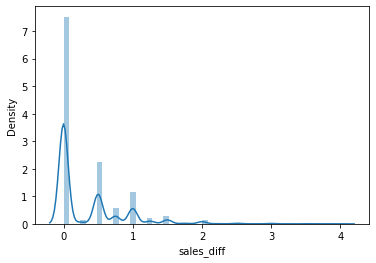

In [334]:
sns.distplot(df_dropna_new[df_dropna_new.sales_diff<4].sales_diff)

/home/hadoop/anaconda3/envs/api/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales_diff_ratio', ylabel='Density'>

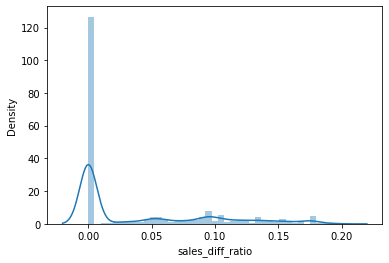

In [335]:
sns.distplot(df_dropna_new[((df_dropna_new.sales_diff_ratio!=np.inf) ) & \
                          (abs(df_dropna_new.sales_diff_ratio)<0.2) ].sales_diff_ratio)

In [336]:
# overall
print(f"The average differece per transaction is: ${df_dropna_new.sales_diff.mean():.2f}")
print(f"The overal error percentage is: {100*df_dropna_new.sales_diff.sum()/df_dropna_new.sales_actual.sum():.2f}%")

# for focus records
df_focus = df_dropna_new[((df_dropna_new.sales_diff_ratio!=np.inf) ) & \
                          (abs(df_dropna_new.sales_diff_ratio)<0.2)]
print("\nFor Focus Group:")
print(f"The average differece per transaction is: ${df_focus.sales_diff.mean():.2f}")
print(f"The overal error percentage is: {100*df_focus.sales_diff.sum()/df_focus.sales_actual.sum():.2f}%")

The average differece per transaction is: $0.52
The overal error percentage is: 6.06%

For Focus Group:
The average differece per transaction is: $0.32
The overal error percentage is: 3.75%


# Conclusion: 
We used actual transaction sales to verified our algorithm, and it showed that th algorithm can sufficiently extract sale items in the transaction. 
The error mainly comes from 
* the inconsistency of item prices (e.g., the same item might have different price.)
* also we only extract price from items appeared individually in the transaction (the other fillna with 0 after join. We probabely can manually fill the rest if desired)

Next, complete df_item_inven, and fill in the ingredients.

In [337]:
# there are 19 items with unkown prices
df_item_inven.sort_values("price_fillna").head(20)

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
329,eGift Card,eGift Card,,,,,#0329#,0.0
30,Beach Bum (12oz ICED),Beach Bum,(12oz ICED),12oz,12,ICED,#0030#,0.0
51,COLOMBIA | Crucero,COLOMBIA | Crucero,,,,,#0051#,0.0
53,COLOMBIA | LOS VENTENOS,COLOMBIA | LOS VENTENOS,,,,,#0053#,0.0
307,Sweet Jams (16oz),Sweet Jams,(16oz),16oz,16,,#0307#,0.0
67,China Breakfast (Regular),China Breakfast,(Regular),,,,#0067#,0.0
69,Chocolate Croissant (Regular Price),Chocolate Croissant,(Regular Price),,,,#0069#,0.0
26,Bao Zhong (Regular),Bao Zhong,(Regular),,,,#0026#,0.0
305,Sweet Jams (12oz),Sweet Jams,(12oz),12oz,12,,#0305#,0.0
79,Creamy / Honey Mint Julep (12oz-- Creamy Mint Julep),Creamy / Honey Mint Julep,(12oz-- Creamy Mint Julep),12oz,12,,#0079#,0.0


In [338]:
df_inven_from_shop = pd.read_csv("./sample_data/inventory.csv")
df_inven_from_shop.head()

,drink,drink temp,milk,syrup,milk quantity,syrup quantity,drink size,cup size,chai
0,latte,hot,whole,NaN,11 oz,1.00,16.0,16.0,NaN
1,cortado,hot,whole,NaN,3 oz,0.00,4.0,4.0,NaN
2,latte,hot,whole,NaN,9 oz,0.75,12.0,12.0,NaN
3,latte,hot,whole,NaN,5 oz,0.50,8.0,8.0,NaN
4,flat white,hot,whole,NaN,4 oz,NaN,6.0,8.0,NaN


In [339]:
# this is not super helpful but gave us a rough idea what consumables are considered
df_inven_from_shop.columns = [e.strip().replace(" ", "_") for e in df_inven_from_shop.columns]
df_inven_from_shop.sort_values(["drink", "drink_size", "drink_temp", "milk", "milk_quantity"])

,drink,drink_temp,milk,syrup,milk_quantity,syrup_quantity,drink_size,cup_size,chai
48,cappucinno,hot,2%,NaN,4 oz,NaN,6.0,8.0,NaN
28,cappucinno,hot,almond,NaN,4 oz,NaN,6.0,8.0,NaN
38,cappucinno,hot,coconut,NaN,4 oz,NaN,6.0,8.0,NaN
18,cappucinno,hot,oat,NaN,4 oz,NaN,6.0,8.0,NaN
5,cappucinno,hot,whole,NaN,4 oz,NaN,6.0,8.0,NaN
49,chai latte,hot,2%,NaN,10 oz,NaN,16.0,16.0,5.0
29,chai latte,hot,almond,NaN,10 oz,NaN,16.0,16.0,5.0
39,chai latte,hot,coconut,NaN,10 oz,NaN,16.0,16.0,5.0
19,chai latte,hot,oat,NaN,10 oz,NaN,16.0,16.0,5.0
6,chai latte,hot,whole,NaN,10 oz,NaN,16.0,16.0,5.0


In [340]:
df_inven_from_shop.count()

drink             52
drink_temp        52
milk              50
syrup              0
milk_quantity     47
syrup_quantity    22
drink_size        47
cup_size          47
chai              15
dtype: int64

In [341]:
df_item_inven.head()

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
0,'Stay Cozy' 16oz Mug (Regular),'Stay Cozy' 16oz Mug,(Regular),16oz,16,,#0000#,15.00
1,*WILD GOOSE GUEST BAKERY* (4.75),*WILD GOOSE GUEST BAKERY*,(4.75),,,,#0001#,4.75
2,*WILD GOOSE GUEST BAKERY* (5),*WILD GOOSE GUEST BAKERY*,(5),,,,#0002#,0.00
3,12 Month Coffee Subscription Gift,12 Month Coffee Subscription Gift - 12 oz,,,,,#0003#,204.00
4,3 Month Coffee Subscription Gift,3 Month Coffee Subscription Gift - 12 oz,,,,,#0004#,51.00


In [342]:
df_item_inven.count()

item_header     330
name            330
extra_info      330
oz              330
size            330
temperature     330
item_id         330
price_fillna    330
dtype: int64

In [343]:
# apparently, we can only take care of coffee here.

df_coffee = df_item_inven[df_item_inven.item_header.str.contains("Cortado") |\
             df_item_inven.item_header.str.contains("Latte") |\
#              df_item_inven.item_header.str.contains("Cappucinno") |\
                          df_item_inven.item_header.str.contains("Cappuccino") |\
                         df_item_inven.item_header.str.contains("Americano") |\
                         df_item_inven.item_header.str.contains("Brew") |\
                          df_item_inven.item_header.str.contains("Coldbrew") |\
#                          (df_item_inven.temperature !='') |\
             df_item_inven.item_header.str.contains("Flat White") \
             ] 

 
# Cappuccino
df_coffee

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
9,Americano (12oz HOT),Americano,(12oz HOT),12oz,12,HOT,#0009#,3.20
10,Americano (12oz ICED),Americano,(12oz ICED),12oz,12,ICED,#0010#,3.20
11,Americano (16oz HOT (quad shot)),Americano,(16oz HOT (quad shot)),16oz,16,HOT,#0011#,3.95
12,Americano (16oz ICED),Americano,(16oz ICED),16oz,16,ICED,#0012#,3.20
13,Americano (8oz HOT),Americano,(8oz HOT),8oz,8,HOT,#0013#,3.20
...,...,...,...,...,...,...,...,...
316,Toasted Coconut Latte (16oz HOT),Toasted Coconut Latte,(16oz HOT),16oz,16,HOT,#0316#,6.00
317,Toasted Coconut Latte (16oz ICED),Toasted Coconut Latte,(16oz ICED),16oz,16,ICED,#0317#,5.25
318,Toasted Coconut Latte (8oz HOT),Toasted Coconut Latte,(8oz HOT),8oz,8,HOT,#0318#,4.75
327,Yama Cold Brew (Single Origin) (12oz),Yama Cold Brew,(Single Origin) (12oz),12oz,12,,#0327#,5.20


In [344]:
# use popularity analysis (i.e., value_counts(): a very powerful tool) to check what we have missed
# first need to unstack (another powerful tool)
lst_col = 'item_ids'
df = df_dropna_new[['Date', 'Time', 'Time Zone', 'Gross Sales', 'Net Sales', 'Source',
       'Card Entry Methods', 'Description', 'Location', 'Customer ID',
       'Customer Name',"item_ids"]].copy()
df_unstack = pd.DataFrame({
        col:np.repeat(df[col].values, df[lst_col].str.len())
        for col in df.columns.difference([lst_col])
    }).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns.tolist()]
df_unstack.head()


,Date,Time,Time Zone,Gross Sales,Net Sales,Source,Card Entry Methods,Description,Location,Customer ID,Customer Name,item_ids
0,05/11/21,16:36:42,Mountain Time (US & Canada),$5.45,$5.45,Point of Sale,Dipped,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,SONDER Coffee,A1RXPQDVKS6HH755X1J8V73C5M,Alondra Ibarra,#0180#
1,05/11/21,16:27:34,Mountain Time (US & Canada),$5.30,$5.30,Point of Sale,NaN,"ROSE Latte (12oz HOT) - fragrant, floral, sweet & fun-- the ROSE latte.",SONDER Coffee,NaN,NaN,#0235#
2,05/11/21,16:26:19,Mountain Time (US & Canada),$3.80,$3.80,Point of Sale,Dipped,Latte (8oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,SONDER Coffee,CHCB4429S94AZFN47FHPXN969W,Shane Bischoff,#0185#
3,05/11/21,16:15:10,Mountain Time (US & Canada),$5.20,$5.20,Point of Sale,Tapped,"Chai Latte (16oz ICED) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai.",SONDER Coffee,T1G6KED8EH2BH83B7CGJWCZEHW,(720) 415-4553,#0062#
4,05/11/21,16:13:45,Mountain Time (US & Canada),$17.30,$17.30,Point of Sale,Dipped,"Ritual Mexico (Regular), ORANGE Latte (12oz HOT) - sweet, fragrant, dreamsicle-like orange blossom latte.",SONDER Coffee,J7Z6VRCNVD1PV3FRT82JHWQQFR,Cierra Mackanos,#0251#


In [345]:
# check what is left (i.e., df_non_coffee)
# go back to df_coffee if anything coffee-like not included
df_non_coffee = df_unstack[~df_unstack.item_ids.isin(df_coffee.item_id.values)].item_ids.value_counts().reset_index()
df_non_coffee.columns = ["index", "counts"]
#df_non_coffee.head(30)

df_left_to_sort = pd.merge(df_non_coffee, df_item_inven,
                          left_on="index", right_on="item_id",
                          how="left")
df_left_to_sort.head(30)

,index,counts,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
0,#0084#,1670,Danish (Regular),Danish,(Regular),,,,#0084#,5.00
1,#0048#,1060,Butter / Plain Croissant (Regular Price),Butter / Plain Croissant,(Regular Price),,,,#0048#,3.50
2,#0008#,1056,Almond Croissant (Regular Price),Almond Croissant,(Regular Price),,,,#0008#,4.75
3,#0234#,1040,Quiche (Regular),Quiche,(Regular),,,,#0234#,7.00
4,#0092#,740,Espresso (Regular),Espresso,(Regular),,,,#0092#,3.20
5,#0167#,605,Kombucha (16oz),Kombucha,(16oz),16oz,16,,#0167#,5.00
6,#0214#,520,On Tap Iced Tea (Large- 16oz),On Tap Iced Tea,(Large- 16oz),16oz,16,Iced,#0214#,4.50
7,#0070#,504,Chocolate Croissant (Regular),Chocolate Croissant,(Regular),,,,#0070#,4.50
8,#0075#,502,Cookies (Regular),Cookies,(Regular),,,,#0075#,3.25
9,#0096#,407,Filled Croissant (Regular),Filled Croissant,(Regular),,,,#0096#,4.50


In [346]:
# it seems like nothing particular import we should include into df_coffee

# there are some coffee pack (e.g., Honduras | Finca Los Olivos (Regular)) but they are not in big sales
# and it is easy to track them from routine inventory check,
# so we are not going to inlude them into df_coffee

# and there is no 0.00 price_fillna
df_coffee.sort_values("price_fillna")

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
29,Batch Brew (8oz),Batch Brew,(8oz),8oz,8,,#0029#,2.5
27,Batch Brew (12oz),Batch Brew,(12oz),12oz,12,,#0027#,3.0
9,Americano (12oz HOT),Americano,(12oz HOT),12oz,12,HOT,#0009#,3.2
10,Americano (12oz ICED),Americano,(12oz ICED),12oz,12,ICED,#0010#,3.2
12,Americano (16oz ICED),Americano,(16oz ICED),16oz,16,ICED,#0012#,3.2
...,...,...,...,...,...,...,...,...
309,Take-Home Chai Latte (Regular),Take-Home Chai Latte,(Regular),,,,#0309#,25.0
310,Take-Home House Latte (Regular),Take-Home House Latte,(Regular),,,,#0310#,25.0
311,Take-Home Oat Milk Latte (Regular),Take-Home Oat Milk Latte,(Regular),,,,#0311#,29.0
312,Take-Home Seasonal Latte (Regular),Take-Home Seasonal Latte,(Regular),,,,#0312#,29.0


In [347]:
# optional: check transaction values one more time
df_dropna_coffee = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: any([(e in df_coffee.item_id.values) for e in x]))]

print("\nFor transactions has coffee:")
print(f"The average differece per transaction is: ${df_dropna_coffee.sales_diff.mean():.2f}")
print(f"The overal error percentage is: {100*df_dropna_coffee.sales_diff.sum()/df_dropna_coffee.sales_actual.sum():.2f}%")

df_dropna_coffee = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x]))]

print("\nFor transactions ONLY has coffee:")
print(f"The average differece per transaction is: ${df_dropna_coffee.sales_diff.mean():.2f}")
print(f"The overal error percentage is: {100*df_dropna_coffee.sales_diff.sum()/df_dropna_coffee.sales_actual.sum():.2f}%")


For transactions has coffee:
The average differece per transaction is: $0.52
The overal error percentage is: 6.24%

For transactions ONLY has coffee:
The average differece per transaction is: $0.43
The overal error percentage is: 6.68%


In [348]:
df_inven_from_shop.sort_values(["drink", "drink_size", "drink_temp", "milk", "milk_quantity"])

,drink,drink_temp,milk,syrup,milk_quantity,syrup_quantity,drink_size,cup_size,chai
48,cappucinno,hot,2%,NaN,4 oz,NaN,6.0,8.0,NaN
28,cappucinno,hot,almond,NaN,4 oz,NaN,6.0,8.0,NaN
38,cappucinno,hot,coconut,NaN,4 oz,NaN,6.0,8.0,NaN
18,cappucinno,hot,oat,NaN,4 oz,NaN,6.0,8.0,NaN
5,cappucinno,hot,whole,NaN,4 oz,NaN,6.0,8.0,NaN
49,chai latte,hot,2%,NaN,10 oz,NaN,16.0,16.0,5.0
29,chai latte,hot,almond,NaN,10 oz,NaN,16.0,16.0,5.0
39,chai latte,hot,coconut,NaN,10 oz,NaN,16.0,16.0,5.0
19,chai latte,hot,oat,NaN,10 oz,NaN,16.0,16.0,5.0
6,chai latte,hot,whole,NaN,10 oz,NaN,16.0,16.0,5.0


In [349]:
df_coffee[df_coffee.item_header.str.contains("Cortado")]

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
76,Cortado (Regular),Cortado,(Regular),,,,#0076#,3.6


In [350]:
df_coffee[df_coffee.item_header.str.contains("Cappuccino")]

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
58,Cappuccino (Regular Cappuccino),Cappuccino,(Regular Cappuccino),,,,#0058#,3.8


In [351]:
df_coffee[df_coffee.item_header.str.contains("Americano")]

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
9,Americano (12oz HOT),Americano,(12oz HOT),12oz,12,HOT,#0009#,3.20
10,Americano (12oz ICED),Americano,(12oz ICED),12oz,12,ICED,#0010#,3.20
11,Americano (16oz HOT (quad shot)),Americano,(16oz HOT (quad shot)),16oz,16,HOT,#0011#,3.95
12,Americano (16oz ICED),Americano,(16oz ICED),16oz,16,ICED,#0012#,3.20
13,Americano (8oz HOT),Americano,(8oz HOT),8oz,8,HOT,#0013#,3.20


In [352]:
df_coffee[df_coffee.item_header.str.contains("Latte")]

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
19,Auburn Harvest (Sweet Potato Pie Latte) (12oz hot),Auburn Harvest,(Sweet Potato Pie Latte) (12oz hot),12oz,12,hot,#0019#,5.30
20,Auburn Harvest (Sweet Potato Pie Latte) (12oz iced),Auburn Harvest,(Sweet Potato Pie Latte) (12oz iced),12oz,12,iced,#0020#,5.55
21,Auburn Harvest (Sweet Potato Pie Latte) (16oz HOT ONLY),Auburn Harvest,(Sweet Potato Pie Latte) (16oz HOT ONLY),16oz,16,HOT,#0021#,6.05
22,Auburn Harvest (Sweet Potato Pie Latte) (16oz iced),Auburn Harvest,(Sweet Potato Pie Latte) (16oz iced),16oz,16,iced,#0022#,6.30
23,Auburn Harvest (Sweet Potato Pie Latte) (8oz hot),Auburn Harvest,(Sweet Potato Pie Latte) (8oz hot),8oz,8,hot,#0023#,4.80
...,...,...,...,...,...,...,...,...
314,Toasted Coconut Latte (12oz HOT),Toasted Coconut Latte,(12oz HOT),12oz,12,HOT,#0314#,5.25
315,Toasted Coconut Latte (12oz ICED),Toasted Coconut Latte,(12oz ICED),12oz,12,ICED,#0315#,4.75
316,Toasted Coconut Latte (16oz HOT),Toasted Coconut Latte,(16oz HOT),16oz,16,HOT,#0316#,6.00
317,Toasted Coconut Latte (16oz ICED),Toasted Coconut Latte,(16oz ICED),16oz,16,ICED,#0317#,5.25


In [353]:
df_coffee[df_coffee.item_header.str.contains("Brew")]

,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna
27,Batch Brew (12oz),Batch Brew,(12oz),12oz,12,,#0027#,3.00
28,Batch Brew (16oz),Batch Brew,(16oz),16oz,16,,#0028#,3.75
29,Batch Brew (8oz),Batch Brew,(8oz),8oz,8,,#0029#,2.50
49,CHERRY Almond Cold Brew (12OZ),CHERRY Almond Cold Brew,(12OZ),12OZ,12,,#0049#,5.00
50,CHERRY Almond Cold Brew (16OZ),CHERRY Almond Cold Brew,(16OZ),16OZ,16,,#0050#,5.50
65,Cherry Almond Cold Brew (12OZ),Cherry Almond Cold Brew,(12OZ),12OZ,12,,#0065#,5.00
66,Cherry Almond Cold Brew (16OZ),Cherry Almond Cold Brew,(16OZ),16OZ,16,,#0066#,5.50
114,GRAPEFRUIT Rosemary Cold Brew (12OZ),GRAPEFRUIT Rosemary Cold Brew,(12OZ),12OZ,12,,#0114#,5.00
115,GRAPEFRUIT Rosemary Cold Brew (16OZ),GRAPEFRUIT Rosemary Cold Brew,(16OZ),16OZ,16,,#0115#,5.50
126,Grapefruit Rosemary Cold Brew (12OZ),Grapefruit Rosemary Cold Brew,(12OZ),12OZ,12,,#0126#,5.00


In [354]:
df_coffee_tmp = df_item_inven[df_item_inven.item_header.str.contains("Cortado") |\
             df_item_inven.item_header.str.contains("Latte") |\
#              df_item_inven.item_header.str.contains("Cappucinno") |\
                          df_item_inven.item_header.str.contains("Cappuccino") |\
                         df_item_inven.item_header.str.contains("Americano") |\
                         df_item_inven.item_header.str.contains("(B|b)rew") |\
                          df_item_inven.item_header.str.contains("Coldbrew") |\
#                          (df_item_inven.temperature !='') |\
             df_item_inven.item_header.str.contains("Flat White") \
             ] 
df_coffee[~df_coffee.item_id.isin(df_coffee_tmp.item_id)]

/home/hadoop/anaconda3/envs/api/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,item_header,name,extra_info,oz,size,temperature,item_id,price_fillna


In [355]:
df_dropna_new[df_dropna_new.Description.str.contains("Flat White")]

,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts,item_prices_trans,sales_match,sales_actual,sales_diff,sales_diff_ratio
11,05/11/21,15:44:30,Mountain Time (US & Canada),$4.30,$4.30,$5.72,"Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward",Payment,NaN,Square Online,On File,SONDER Coffee,F8SS0P2Z5N2XDFKC364HXDMQV0,Nikki Libertelli,[Flat White (Regular)],[#0107#],1,[3.8],3.80,4.30,0.5,0.116279
70,05/11/21,10:29:55,Mountain Time (US & Canada),$3.80,$3.80,$6.08,"Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,VMX1G2FTK94EFA2WJ6F4SD4YNM,Laura Gonzalez,[Flat White (Regular)],[#0107#],1,[3.8],3.80,3.80,0.0,0.000000
86,05/11/21,09:35:06,Mountain Time (US & Canada),$3.80,$3.80,$4.08,"Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,Z87M8TYPND02TXXP4NRE1CT6KW,Veronika Girenko,[Flat White (Regular)],[#0107#],1,[3.8],3.80,3.80,0.0,0.000000
99,05/11/21,08:42:52,Mountain Time (US & Canada),$3.80,$3.80,$5.08,"Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,8DSHMNRDZN6VPWKNMSSXEVX6XC,Sergei Egorov,[Flat White (Regular)],[#0107#],1,[3.8],3.80,3.80,0.0,0.000000
181,05/10/21,10:20:57,Mountain Time (US & Canada),$3.80,$3.80,$4.08,"Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,28N0KXQDZ10WK1SCXCDKDPSDFG,Tara Mcclanahan,[Flat White (Regular)],[#0107#],1,[3.8],3.80,3.80,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38688,05/15/20,15:08:08,Mountain Time (US & Canada),$7.40,$2.40,$4.00,"Cortado (Regular) - double espresso with two ounces of steamed milk, Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,P4FKMKTHV92PZ757JV7Y2NYXD0,Andreatta Tsosie,"[Cortado (Regular), Flat White (Regular)]","[#0076#, #0107#]",2,"[3.6, 3.8]",7.40,7.40,0.0,0.000000
38767,05/14/20,15:03:27,Mountain Time (US & Canada),$9.25,$9.25,$12.64,"Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward, Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz LARGE lattes come with four shots by default \n",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,GXA0032TR95RB6FFY9Y4DSXC8C,Katrina Slaughter,"[Flat White (Regular), Latte (16oz HOT (quad shot))]","[#0107#, #0182#]",2,"[3.8, 4.95]",8.75,9.25,0.5,0.054054
38860,05/13/20,13:28:55,Mountain Time (US & Canada),$9.30,$3.80,$5.96,"Honey Pistachio Cold Brew (16OZ), Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,VYGZ7AG4ZS4692CFG6P5GPYRCR,Jennifer Quinn,"[Honey Pistachio Cold Brew (16OZ), Flat White (Regular)]","[#0151#, #0107#]",2,"[5.5, 3.8]",9.30,9.30,0.0,0.000000
38897,05/13/20,10:35:32,Mountain Time (US & Canada),$3.80,$0.00,$0.00,"Flat White (Regular) - double shot with four ounces of milk, low foam and crema forward",Payment,NaN,Point of Sale,NaN,SONDER Coffee,NaN,NaN,[Flat White (Regular)],[#0107#],1,[3.8],3.80,3.80,0.0,0.000000


In [356]:
# inspect the negative transaction
# when looking around we can figure out more
df_trnsc["Event Type"].unique()

df_dropna_new[df_dropna_new["Gross Sales"].str.contains("-")]

index_select = df_trnsc[df_trnsc["Event Type"]=="Refund"].index.to_list()
index_select
index_list=[]
for e in index_select:
    index_list+=list((e-1,e,e+1))
index_list
    
np.array([list((e-1,e,e+1)) for e in index_select]).ravel()

df_trnsc.loc[np.array([list((e,e+1)) for e in index_select]).ravel()].head(50)


,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Square Gift Card,Other Tender,Other Tender Type,Other Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Staff Name,Staff ID,Details,Description,Event Type,Location,Dining Option,Customer ID,Customer Name,Customer Reference ID,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
1596,04/28/21,12:27:53,Mountain Time (US & Canada),$-4.70,$0.00,$-4.70,$0.00,$-0.35,$0.00,$0.00,$-5.05,Point of Sale,$-5.05,Tapped,$0.00,$0.00,$0.00,NaN,NaN,$0.13,$-4.92,hLreEqmI2Fh77u0faFqeygteV,ZCxl3nxIbYPbF7YpZkjqduDrvaB,Visa,6943,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/hLreEqmI2Fh77u0faFqeygteV/by-unit/7GW3QTHDACDY4,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZVEEM7SD8K08YQA06BY12E74ZEN,04/28/21,https://squareup.com/dashboard/sales/deposits/3ZVEEM7SD8K08YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned Goods,NaN,Complete,NaN
1597,04/28/21,12:27:13,Mountain Time (US & Canada),$4.70,$0.00,$4.70,$0.00,$0.35,$1.00,$0.00,$6.05,Point of Sale,$6.05,Tapped,$0.00,$0.00,$0.00,NaN,NaN,$-0.26,$5.79,11FXU1OhaVxOf4E8OxbkslheV,ZCxl3nxIbYPbF7YpZkjqduDrvaB,Visa,6943,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/11FXU1OhaVxOf4E8OxbkslheV/by-unit/7GW3QTHDACDY4,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,SONDER Coffee,NaN,RKBDJRKEQD0ZB7TK1QQC9ZKNTM,Carly Kloack,NaN,NaN,3ZVEEM7SD8K08YQA06BY12E74ZEN,04/28/21,https://squareup.com/dashboard/sales/deposits/3ZVEEM7SD8K08YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.6,$0.10,NaN,NaN,Complete,NaN
2579,04/19/21,11:16:49,Mountain Time (US & Canada),$-5.45,$0.00,$-5.45,$0.00,$-0.41,$0.00,$0.00,$-5.86,Point of Sale,$0.00,NaN,$-5.86,$0.00,$0.00,NaN,NaN,$0.00,$-5.86,JpuLl1Wt8l70EG2lJZk6tNAfV,HVty6pTRUGnP1be15lt27PnbuaB,NaN,NaN,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/JpuLl1Wt8l70EG2lJZk6tNAfV/by-unit/7GW3QTHDACDY4,Matcha Latte (12oz HOT) - organic pure matcha green tea with milk,Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accidental Charge,NaN,Complete,NaN
2580,04/19/21,11:15:47,Mountain Time (US & Canada),$5.45,$0.00,$5.45,$0.00,$0.41,$5.00,$0.00,$10.86,Point of Sale,$10.86,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$-0.38,$10.48,L6AeCWwJojp3yKOo5oDwK9ieV,DbH1ivVfzDQgjdxQ72JflXBduaB,Visa,4412,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/L6AeCWwJojp3yKOo5oDwK9ieV/by-unit/7GW3QTHDACDY4,Matcha Latte (12oz HOT) - organic pure matcha green tea with milk,Payment,SONDER Coffee,NaN,X22SS811CD1G12JY5EQ655GYC0,Janna Yoshimoto,NaN,NaN,3Z5FP7C5N1GR8YQ3THBY12E74ZE9,04/19/21,https://squareup.com/dashboard/sales/deposits/3Z5FP7C5N1GR8YQ3THBY12E74ZE9/by-unit/7GW3QTHDACDY4,2.6,$0.10,NaN,NaN,Complete,NaN
2792,04/17/21,15:40:49,Mountain Time (US & Canada),$0.00,$0.00,$0.00,$0.00,$0.00,$-100.00,$0.00,$-100.00,Point of Sale,$-100.00,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$2.60,$-97.40,vYsJyWBUEBHsHMhLzD9kfsieV,hgmx1eMpEhdkG585LldiEIHvvaB,Visa,9097,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/vYsJyWBUEBHsHMhLzD9kfsieV/by-unit/7GW3QTHDACDY4,NaN,Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZSNHP4450PW8YQ3THBY12E74ZE9,04/18/21,https://squareup.com/dashboard/sales/deposits/3ZSNHP4450PW8YQ3THBY12E74ZE9/by-unit/7GW3QTHDACDY4,2.6,$0.10,Accidental Charge,NaN,Complete,NaN
2793,04/17/21,15:40:01,Mountain Time (US & Canada),$9.70,$0.00,$9.70,$0.00,$0.73,$100.00,$0.00,$110.43,Point of Sale,$110.43,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$-2.97,$107.46,r66biXigLpyNgLtRPKlbYB5eV,hgmx1eMpEhdkG585LldiEIHvvaB,Visa,9097,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/r66biXigLpyNgLtRPKlbYB5eV/by-unit/7GW3QTHDACDY4,"Dani

In [357]:
print(df_trnsc["Refund Reason"].unique())
print(df_trnsc["Event Type"].unique())

[nan 'Returned Goods' 'Accidental Charge' 'Canceled Order'
 'Returned goods' 'Accidental charge' 'Rewards' 'Canceled order'
 'Forgot Items' 'Anniversary Treat ' 'We’re closed!']
['Payment' 'Refund']


In [358]:
index_select = df_trnsc[df_trnsc["Gross Sales"]=="$0.00"].index.to_list()
df_trnsc.loc[np.array([e for e in index_select]).ravel()].head(50)

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Square Gift Card,Other Tender,Other Tender Type,Other Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Staff Name,Staff ID,Details,Description,Event Type,Location,Dining Option,Customer ID,Customer Name,Customer Reference ID,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
273,05/09/21,10:47:00,Mountain Time (US & Canada),$0.00,$0.00,$0.00,$40.00,$0.00,$0.00,$0.00,$40.00,eGift Cards,$40.00,Keyed,$0.00,$0.00,$0.00,NaN,NaN,$-1.46,$38.54,XIeFLW99AOBDGMSMUMB9mf7eV,dUNnX1zbyw3rwAFCcJu7H8z4uaB,MasterCard,1423,NaN,NaN,NaN,https://squareup.com/dashboard/sales/transactions/XIeFLW99AOBDGMSMUMB9mf7eV/by-unit/7GW3QTHDACDY4,eGift Card,Payment,SONDER Coffee,NaN,Z4RDA2EFRS3PBABT2BFENS2JD4,Daniel Orne,NaN,NaN,3Z8FV5X7XH708YQA06BY12E74ZEN,05/09/21,https://squareup.com/dashboard/sales/deposits/3Z8FV5X7XH708YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.9,$0.30,NaN,20% off,Complete,NaN
336,05/09/21,06:48:39,Mountain Time (US & Canada),$0.00,$0.00,$0.00,$20.00,$0.00,$0.00,$0.00,$20.00,eGift Cards,$20.00,Keyed,$0.00,$0.00,$0.00,NaN,NaN,$-0.88,$19.12,vaveQysYDG8Zx2LJl4W73AheV,5uzRgxeameiWlBwHvFPEOdnwvaB,Visa,9016,NaN,NaN,NaN,https://squareup.com/dashboard/sales/transactions/vaveQysYDG8Zx2LJl4W73AheV/by-unit/7GW3QTHDACDY4,eGift Card,Payment,SONDER Coffee,NaN,WSPRCYKKG0YKDAZ7AZT9ZZSV3G,Drew Garland,NaN,NaN,3Z8FV5X7XH708YQA06BY12E74ZEN,05/09/21,https://squareup.com/dashboard/sales/deposits/3Z8FV5X7XH708YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.9,$0.30,NaN,20% off,Complete,NaN
456,05/08/21,09:07:17,Mountain Time (US & Canada),$0.00,$0.00,$0.00,$30.00,$0.00,$0.00,$0.00,$30.00,Point of Sale,$30.00,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$-0.88,$29.12,LUvXIFPhSXnWQ2R9eJaOJrveV,BeT2629m6cCL7JKXzAzbmTwyvaB,Visa,0744,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/LUvXIFPhSXnWQ2R9eJaOJrveV/by-unit/7GW3QTHDACDY4,Gift Card,Payment,SONDER Coffee,NaN,1EKJ8R4F9D687883PWTY3C1FY4,Casey Ballinger,NaN,NaN,3Z8FV5X7XH708YQA06BY12E74ZEN,05/09/21,https://squareup.com/dashboard/sales/deposits/3Z8FV5X7XH708YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.6,$0.10,NaN,NaN,Complete,NaN
620,05/06/21,16:03:09,Mountain Time (US & Canada),$0.00,$0.00,$0.00,$20.00,$0.00,$0.00,$0.00,$20.00,eGift Cards,$20.00,Keyed,$0.00,$0.00,$0.00,NaN,NaN,$-0.88,$19.12,dBbeN9sOKe53FsSHd6G875reV,zhqTE63osjgUPqouRIeJnpC4uaB,MasterCard,8214,NaN,NaN,NaN,https://squareup.com/dashboard/sales/transactions/dBbeN9sOKe53FsSHd6G875reV/by-unit/7GW3QTHDACDY4,eGift Card,Payment,SONDER Coffee,NaN,BYYT89DHK0T9KFFG3FW64C19VM,Mary Henneberry,NaN,NaN,3Z9H6JG75EW88YQA06BY12E74ZEN,05/06/21,https://squareup.com/dashboard/sales/deposits/3Z9H6JG75EW88YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.9,$0.30,NaN,20% off,Complete,NaN
732,05/05/21,15:33:50,Mountain Time (US & Canada),$0.00,$0.00,$0.00,$50.00,$0.00,$0.00,$0.00,$50.00,Point of Sale,$0.00,NaN,$50.00,$0.00,$0.00,NaN,NaN,$0.00,$50.00,bAns9l8JkGgLTyYhP9O84L0eV,RWHM4jDEU4uY215bWbMVSPmauaB,NaN,NaN,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/bAns9l8JkGgLTyYhP9O84L0eV/by-unit/7GW3QTHDACDY4,Gift Card,Payment,SONDER Coffee,NaN,DTCAA0B06N4R2Y3RRCFZ5735Z8,Thomas Barrett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete,NaN
1080,05/02/21,11:22:08,Mountain Time (US & Canada),$0.00,$0.00,$0.00,$16.00,$0.00,$0.00,$0.00,$16.00,eGift Cards,$16.00,Keyed,$0.00,$0.00,$0.00,NaN,NaN,$-0.76,$15.24,TEJ7H6wNEGLHBJdbwtq5PO3eV,1KM8LHheuWChzFBnzd3FzSG2uaB,Visa,1277,NaN,NaN,NaN,https://squareup.com/dashboard/sales/transactions/TEJ7H6wNEGLHBJdbwtq5PO3eV/by-unit/7GW3QTHDACDY4,eGift Card,Payment,SONDER Coffee,NaN,PXD45EN1056B19EDZ1TFN851QM,Catherine Strayhall,NaN,NaN,3Z6DK2E1DBQ08YQA06BY12E74ZEN,05/02/21,https://squareup.com/dashboard/sales/deposits/3Z6DK2E1DBQ08YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.9,$0.3

In [359]:
df_trnsc["Source"].unique()

array(['Point of Sale', 'Square Online', 'WooCommerce', 'eGift Cards',
       'QR Code', 'Online Store'], dtype=object)

In [360]:
df_trnsc[df_trnsc["Total Collected"].str.contains("-")]

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Square Gift Card,Other Tender,Other Tender Type,Other Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Staff Name,Staff ID,Details,Description,Event Type,Location,Dining Option,Customer ID,Customer Name,Customer Reference ID,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
1596,04/28/21,12:27:53,Mountain Time (US & Canada),$-4.70,$0.00,$-4.70,$0.00,$-0.35,$0.00,$0.00,$-5.05,Point of Sale,$-5.05,Tapped,$0.00,$0.00,$0.00,NaN,NaN,$0.13,$-4.92,hLreEqmI2Fh77u0faFqeygteV,ZCxl3nxIbYPbF7YpZkjqduDrvaB,Visa,6943,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/hLreEqmI2Fh77u0faFqeygteV/by-unit/7GW3QTHDACDY4,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZVEEM7SD8K08YQA06BY12E74ZEN,04/28/21,https://squareup.com/dashboard/sales/deposits/3ZVEEM7SD8K08YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned Goods,NaN,Complete,NaN
2579,04/19/21,11:16:49,Mountain Time (US & Canada),$-5.45,$0.00,$-5.45,$0.00,$-0.41,$0.00,$0.00,$-5.86,Point of Sale,$0.00,NaN,$-5.86,$0.00,$0.00,NaN,NaN,$0.00,$-5.86,JpuLl1Wt8l70EG2lJZk6tNAfV,HVty6pTRUGnP1be15lt27PnbuaB,NaN,NaN,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/JpuLl1Wt8l70EG2lJZk6tNAfV/by-unit/7GW3QTHDACDY4,Matcha Latte (12oz HOT) - organic pure matcha green tea with milk,Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accidental Charge,NaN,Complete,NaN
2792,04/17/21,15:40:49,Mountain Time (US & Canada),$0.00,$0.00,$0.00,$0.00,$0.00,$-100.00,$0.00,$-100.00,Point of Sale,$-100.00,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$2.60,$-97.40,vYsJyWBUEBHsHMhLzD9kfsieV,hgmx1eMpEhdkG585LldiEIHvvaB,Visa,9097,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/vYsJyWBUEBHsHMhLzD9kfsieV/by-unit/7GW3QTHDACDY4,NaN,Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZSNHP4450PW8YQ3THBY12E74ZE9,04/18/21,https://squareup.com/dashboard/sales/deposits/3ZSNHP4450PW8YQ3THBY12E74ZE9/by-unit/7GW3QTHDACDY4,2.6,$0.10,Accidental Charge,NaN,Complete,NaN
3153,04/14/21,12:24:47,Mountain Time (US & Canada),$-9.50,$2.00,$-7.50,$0.00,$-0.56,$-1.00,$0.00,$-9.06,Point of Sale,$-9.06,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$0.34,$-8.72,BbtvUmDkzB4Hpm9hVv5nUQ6eV,DbZ6wZgMqLx2VgqbZIppkfF3uaB,Visa,1993,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/BbtvUmDkzB4Hpm9hVv5nUQ6eV/by-unit/7GW3QTHDACDY4,"Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n, LIME Latte (16oz ICED) - key lime espresso latte",Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZHS8MK8CXK08YQ3THBY12E74ZE9,04/14/21,https://squareup.com/dashboard/sales/deposits/3ZHS8MK8CXK08YQ3THBY12E74ZE9/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned Goods,$2 OFF ANY MENU ITEM // ILIFF SHOP ONLY,Complete,NaN
3160,04/14/21,11:56:01,Mountain Time (US & Canada),$-2.25,$0.00,$-2.25,$0.00,$-0.17,$0.00,$0.00,$-2.42,Point of Sale,$-2.42,Tapped,$0.00,$0.00,$0.00,NaN,NaN,$0.06,$-2.36,7cR0iCYbnAIpTWz2KmkoJ3leV,14RvT0NtGTsSuPOsGzWC2NFouaB,Visa,2457,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/7cR0iCYbnAIpTWz2KmkoJ3leV/by-unit/7GW3QTHDACDY4,Topo Chico/Fiji (Regular Price),Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZHS8MK8CXK08YQ3THBY12E74ZE9,04/14/21,https://squareup.com/dashboard/sales/deposits/3ZHS8MK8CXK08YQ3THBY12E74ZE9/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned Goods,NaN,Complete,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36552,06/08/20,14:20:46,Mountain Time (US & Canada),$-4.70,$0.00,$-4.70,$0.00,$-0.39,$-0.94,$0.00,$-6.03,Point of Sale,$-6.03,On File,$0.00,$0.00,$0.00,

In [361]:
df_trnsc[df_trnsc["Gross Sales"] != df_trnsc["Net Sales"]]

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Square Gift Card,Other Tender,Other Tender Type,Other Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Staff Name,Staff ID,Details,Description,Event Type,Location,Dining Option,Customer ID,Customer Name,Customer Reference ID,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
7,05/11/21,15:58:13,Mountain Time (US & Canada),$10.20,$-5.00,$5.20,$0.00,$0.39,$2.00,$0.00,$7.59,Point of Sale,$7.59,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$-0.30,$7.29,vgOwaGwbkdKganlXTU8iPAteV,LfLJxksuKI3udvcifefbIRwnvaB,Visa,5287,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/vgOwaGwbkdKganlXTU8iPAteV/by-unit/7GW3QTHDACDY4,"Nitro Coldbrew (16oz) - on tap nitro cold brew; a chocolately, balanced and light house blend. , Hand Brew (Current Selection) - a featured single-origin coffee brewed on v60 by hand, 10oz.",Payment,SONDER Coffee,NaN,FW7Y5602593FZ7Z732XVEQQ368,Olivia Green,NaN,NaN,NaN,NaN,NaN,2.6,$0.10,NaN,FREE DRINK!,Complete,NaN
8,05/11/21,15:55:59,Mountain Time (US & Canada),$5.30,$-2.00,$3.30,$0.00,$0.25,$0.00,$0.00,$3.55,Point of Sale,$3.55,Tapped,$0.00,$0.00,$0.00,NaN,NaN,$-0.19,$3.36,3axUQduVacdZpZzaGqWvFvreV,3FR8J7I0Youob4JoJJMjG0dDvaB,Visa,9776,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/3axUQduVacdZpZzaGqWvFvreV/by-unit/7GW3QTHDACDY4,"ORANGE Latte (16oz ICED) - sweet, fragrant, dreamsicle-like orange blossom latte.",Payment,SONDER Coffee,NaN,QY72K2TMD117SAZTSWS0GXGKJR,Vienna Wong,NaN,NaN,NaN,NaN,NaN,2.6,$0.10,NaN,$2 OFF ANY MENU ITEM // ILIFF SHOP ONLY,Complete,NaN
9,05/11/21,15:54:57,Mountain Time (US & Canada),$5.50,$-2.00,$3.50,$0.00,$0.26,$0.00,$0.00,$3.76,Point of Sale,$3.76,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$-0.20,$3.56,pdasBIJv6f3FxsP50EqTaQreV,Hh5JgfVUWLYJ7WpWBMh3Wh0KvaB,MasterCard,7712,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/pdasBIJv6f3FxsP50EqTaQreV/by-unit/7GW3QTHDACDY4,KIWI Matcha (16OZ) - kiwi inspired matcha & chia mocktail,Payment,SONDER Coffee,NaN,WZJD0Y4HP132KCSSBAAVJ2W374,Kevina Wong,NaN,NaN,NaN,NaN,NaN,2.6,$0.10,NaN,Get $2 off the next time you visit!,Complete,NaN
23,05/11/21,13:49:12,Mountain Time (US & Canada),$3.70,$-2.00,$1.70,$0.00,$0.13,$0.00,$0.00,$1.83,Point of Sale,$1.83,Tapped,$0.00,$0.00,$0.00,NaN,NaN,$-0.15,$1.68,vEO3gDT2wYnVtJQ47WTo0q2eV,rl8CAMMfg5hO5Yn0SCqAuFbjuaB,Visa,0299,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/vEO3gDT2wYnVtJQ47WTo0q2eV/by-unit/7GW3QTHDACDY4,Americano (16oz ICED) - double espresso over water,Payment,SONDER Coffee,NaN,V3M834E8BN47XEQ981BGQV56QG,Brittaney Caldwell,11eaa2c77e03473485260cc47a2b63ac,NaN,NaN,NaN,NaN,2.6,$0.10,NaN,$2 OFF ANY MENU ITEM // ILIFF SHOP ONLY,Complete,NaN
30,05/11/21,13:16:11,Mountain Time (US & Canada),$4.70,$-0.47,$4.23,$0.00,$0.32,$0.00,$0.00,$4.55,Point of Sale,$0.00,NaN,$4.55,$0.00,$0.00,NaN,NaN,$0.00,$4.55,HEYdrZGTPQu5PAngtNkQd9weV,poIr41IfdZ0jvKOudkRWxsUBvaB,NaN,NaN,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/HEYdrZGTPQu5PAngtNkQd9weV/by-unit/7GW3QTHDACDY4,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Payment,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lugano Residents Discount,Complete,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39041,05/11/20,09:33:21,Mountain Time (US & Canada),$5.25,$-0.52,$4.73,$0.00,$0.20,$1.00,$0.00,$5.93,Point of Sale,$5.93,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$-0.25,$5.68,jGmzPSD26QQIGTk9D3PqYM7eV,5I6st4SokobRjku9UWmMOP75taB,Visa,5154,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/jGmzPSD26QQIGTk9D3PqYM7eV/by-unit/7GW3QTHDACDY

### About negative Gross sales

# Conclusion
When determine whether certain transaction contain consumeralbes (e.g., milk, cups), it has to be
**a "Payment" type (i.e., not "Refund" type) in "Event Type"**

When it is a "Refund type", there are two scenarios
### scenario 1: "Refund Reason" is one of the following:

 'Accidental Charge', 'Canceled Order', 'Accidental charge', 'Canceled order', 'Forgot Items', 'We’re closed!'
 
In this case, there is **NO consumerable spent**. So, the algorithm need to use "negative" amount (e.g., milk spent == -10 oz) to compensate the assocaited consumerable tracking. 
Note: in SquareUp API, it uses a similar idea of negative "Gross Sales" to make the state reflect refunds.

### scenario 2: "Refund Reason" is one the following (the remaining part after scenario 1)
'Returned Goods', 'returned goods', 'Rewards' , 'Anniversary Treat '

In this scenario, **consumer is spent (and assuming not resalable)**, so the consumerable tracker just ignore such records and do nothing

### About zero Gross sales
It would be either egift sales or error logging. In either case, the tracker can handle the transaction records by ignoring it.
 

In [362]:
df_tmp = df_trnsc[df_trnsc["Refund Reason"].notna()]
df_tmp[df_tmp["Refund Reason"].str.contains(r"Goods|goods")]

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Square Gift Card,Other Tender,Other Tender Type,Other Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Staff Name,Staff ID,Details,Description,Event Type,Location,Dining Option,Customer ID,Customer Name,Customer Reference ID,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
1596,04/28/21,12:27:53,Mountain Time (US & Canada),$-4.70,$0.00,$-4.70,$0.00,$-0.35,$0.00,$0.00,$-5.05,Point of Sale,$-5.05,Tapped,$0.00,$0.00,$0.00,NaN,NaN,$0.13,$-4.92,hLreEqmI2Fh77u0faFqeygteV,ZCxl3nxIbYPbF7YpZkjqduDrvaB,Visa,6943,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/hLreEqmI2Fh77u0faFqeygteV/by-unit/7GW3QTHDACDY4,Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n,Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZVEEM7SD8K08YQA06BY12E74ZEN,04/28/21,https://squareup.com/dashboard/sales/deposits/3ZVEEM7SD8K08YQA06BY12E74ZEN/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned Goods,NaN,Complete,NaN
3153,04/14/21,12:24:47,Mountain Time (US & Canada),$-9.50,$2.00,$-7.50,$0.00,$-0.56,$-1.00,$0.00,$-9.06,Point of Sale,$-9.06,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$0.34,$-8.72,BbtvUmDkzB4Hpm9hVv5nUQ6eV,DbZ6wZgMqLx2VgqbZIppkfF3uaB,Visa,1993,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/BbtvUmDkzB4Hpm9hVv5nUQ6eV/by-unit/7GW3QTHDACDY4,"Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n, LIME Latte (16oz ICED) - key lime espresso latte",Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZHS8MK8CXK08YQ3THBY12E74ZE9,04/14/21,https://squareup.com/dashboard/sales/deposits/3ZHS8MK8CXK08YQ3THBY12E74ZE9/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned Goods,$2 OFF ANY MENU ITEM // ILIFF SHOP ONLY,Complete,NaN
3160,04/14/21,11:56:01,Mountain Time (US & Canada),$-2.25,$0.00,$-2.25,$0.00,$-0.17,$0.00,$0.00,$-2.42,Point of Sale,$-2.42,Tapped,$0.00,$0.00,$0.00,NaN,NaN,$0.06,$-2.36,7cR0iCYbnAIpTWz2KmkoJ3leV,14RvT0NtGTsSuPOsGzWC2NFouaB,Visa,2457,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/7cR0iCYbnAIpTWz2KmkoJ3leV/by-unit/7GW3QTHDACDY4,Topo Chico/Fiji (Regular Price),Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZHS8MK8CXK08YQ3THBY12E74ZE9,04/14/21,https://squareup.com/dashboard/sales/deposits/3ZHS8MK8CXK08YQ3THBY12E74ZE9/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned Goods,NaN,Complete,NaN
5068,03/28/21,16:41:46,Mountain Time (US & Canada),$-5.45,$0.00,$-5.45,$0.00,$-0.41,$0.00,$0.00,$-5.86,Point of Sale,$-5.86,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$0.15,$-5.71,pl2UFbB7VN9KvijXg7RgS28eV,J6XoLxDHWcCSH8nsOyM8aOrluaB,Visa,8655,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/pl2UFbB7VN9KvijXg7RgS28eV/by-unit/7GW3QTHDACDY4,"Chai Latte (16oz HOT) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai.",Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZAJTWVQWG6W8YQ3THBY12E74ZE9,03/28/21,https://squareup.com/dashboard/sales/deposits/3ZAJTWVQWG6W8YQ3THBY12E74ZE9/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned Goods,NaN,Complete,NaN
14031,12/31/20,11:04:06,Mountain Time (US & Canada),$-7.00,$0.00,$-7.00,$0.00,$-0.44,$0.00,$0.00,$-7.44,Point of Sale,$-7.44,Dipped,$0.00,$0.00,$0.00,NaN,NaN,$0.20,$-7.24,l3YUXjJJ2SOThwqGFMTVlM3eV,hmJlfkRWHqMl46GnWmwtamBovaB,American Express,1015,Ernest,NaN,NaN,https://squareup.com/dashboard/sales/transactions/l3YUXjJJ2SOThwqGFMTVlM3eV/by-unit/7GW3QTHDACDY4,Quiche (Regular),Refund,SONDER Coffee,NaN,NaN,NaN,NaN,NaN,3ZKCR5T0JBWW8YQ7GEBY12E74ZEN,12/31/20,https://squareup.com/dashboard/sales/deposits/3ZKCR5T0JBWW8YQ7GEBY12E74ZEN/by-unit/7GW3QTHDACDY4,2.6,$0.10,Returned goods,NaN,Complete,NaN
19614,11/02/20,15:38:43,Mountain Time (US & Canada),$-4.70,$0.00,$-4.70,$0.00,$-0.29,$0.00,$

In [363]:
# to-do 1: check if the price is more accurate after take out negative transaction
# optional: check transaction values one more time
df_dropna_coffee = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: any([(e in df_coffee.item_id.values) for e in x])) &
                                ~df_dropna_new["Gross Sales"].str.contains("-")]

print("\nFor transactions has coffee:")
print(f"The average differece per transaction is: ${df_dropna_coffee.sales_diff.mean():.2f}")
print(f"The overal error percentage is: {100*df_dropna_coffee.sales_diff.sum()/df_dropna_coffee.sales_actual.sum():.2f}%")

df_dropna_coffee = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x])) &
                                ~df_dropna_new["Gross Sales"].str.contains("-")]

print("\nFor transactions ONLY has coffee:")
print(f"The average differece per transaction is: ${df_dropna_coffee.sales_diff.mean():.2f}")
print(f"The overal error percentage is: {100*df_dropna_coffee.sales_diff.sum()/df_dropna_coffee.sales_actual.sum():.2f}%")


For transactions has coffee:
The average differece per transaction is: $0.50
The overal error percentage is: 6.04%

For transactions ONLY has coffee:
The average differece per transaction is: $0.41
The overal error percentage is: 6.43%


# Conclusion:
By excluding the negative transactions, the price tag makes more sense. But again, the error is still from the inconsistency of the item prices, which is hard to resolve for now.

In [364]:
# to-do 2: can milk type be distinguished (i.e., if there is any info about customer choice of Almond milk, 2% milk)

# ------------
# "whole" is not a valid option, verify with the following
df_tmp = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x])) & 
                                 df_dropna_new.Description.str.contains("whole")]
# df_tmp.head(50)

df_tmp = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x])) & 
                                 df_dropna_new.Description.str.contains("whole") &\
                       ~df_dropna_new.Description.str.contains("LEMON Poppyseed Matcha Latte")
                      ]
df_tmp.head(50)
# --------------
df_tmp = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x])) & 
                                 df_dropna_new.Description.str.contains("coconut")]
df_tmp.head(50)

df_tmp = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x])) & 
                                 df_dropna_new.Description.str.contains("coconut") &\
                       ~df_dropna_new.Description.str.contains("PISTACHIO Cold Brew")]
df_tmp.head(50)

# please specify to sub cream for oat, coconut or almond milk


,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts,item_prices_trans,sales_match,sales_actual,sales_diff,sales_diff_ratio
9981,02/10/21,07:20:57,Mountain Time (US & Canada),$10.45,$10.45,$11.10,"Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default \n, Maple Woods (Spiced Maple Cold Brew) (12oz) - spiced maple shaken with cold brew and cream // please specify to sub cream for oat, coconut or almond milk",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,65AB04F27D609CXN71XSM899DR,Katelyn Cerullo,"[Latte (16oz HOT (quad shot)), Maple Woods (Spiced Maple Cold Brew) (12oz)]","[#0182#, #0190#]",2,"[4.95, 5.0]",9.95,10.45,0.50,0.047847
10099,02/08/21,12:38:02,Mountain Time (US & Canada),$10.30,$10.30,$13.13,"Maple Woods (Spiced Maple Cold Brew) (12oz) - spiced maple shaken with cold brew and cream // please specify to sub cream for oat, coconut or almond milk , Auburn Harvest (Sweet Potato Pie Latte) (12oz hot) - organic sweet potato sauce infused with fall spices, and topped with torched marshmallows // 16oz HOT lattes come with four shots by default",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,PPMTQ0Z84S1CWV4734R5G27VWW,Bailey Monroe,"[Maple Woods (Spiced Maple Cold Brew) (12oz), Auburn Harvest (Sweet Potato Pie Latte) (12oz hot)]","[#0190#, #0019#]",2,"[5.0, 5.3]",10.30,10.30,0.00,0.000000
10228,02/07/21,10:10:15,Mountain Time (US & Canada),$5.50,$5.50,$6.34,"Maple Woods (Spiced Maple Cold Brew) (16oz) - spiced maple shaken with cold brew and cream // please specify to sub cream for oat, coconut or almond milk",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,DJ5FCTNBRS56NAST4X39QTAJ1C,Nicholas Sciubba,[Maple Woods (Spiced Maple Cold Brew) (16oz)],[#0191#],1,[5.5],5.50,5.50,0.00,0.000000
10254,02/07/21,09:11:52,Mountain Time (US & Canada),$9.20,$4.20,$6.46,"Maple Woods (Spiced Maple Cold Brew) (12oz) - spiced maple shaken with cold brew and cream // please specify to sub cream for oat, coconut or almond milk , Nitro Coldbrew (12oz) - on tap nitro cold brew; a chocolate, balanced and clean house blend.",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,4PFJ6SK1K13AB5CKBMFMQWASDR,Jeffrey Stevens,"[Maple Woods (Spiced Maple Cold Brew) (12oz), Nitro Coldbrew (12oz)]","[#0190#, #0206#]",2,"[5.0, 4.2]",9.20,9.20,0.00,0.000000
10273,02/07/21,07:37:30,Mountain Time (US & Canada),$10.95,$10.95,$13.63,"Maple Woods (Spiced Maple Cold Brew) (16oz) - spiced maple shaken with cold brew and cream // please specify to sub cream for oat, coconut or almond milk , Latte (16oz HOT (quad shot)) - double espresso with milk // 16oz HOT lattes come with four shots by default \n",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,65AB04F27D609CXN71XSM899DR,Katelyn Cerullo,"[Maple Woods (Spiced Maple Cold Brew) (16oz), Latte (16oz HOT (quad shot))]","[#0191#, #0182#]",2,"[5.5, 4.95]",10.45,10.95,0.50,0.045662
10306,02/06/21,14:08:16,Mountain Time (US & Canada),$5.50,$5.50,$6.84,"Maple Woods (Spiced Maple Cold Brew) (16oz) - spiced maple shaken with cold brew and cream // please specify to sub cream for oat, coconut or almond milk",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,V2133RQJY10GF4A9PZXBTCHFYM,(480) 226-4165,[Maple Woods (Spiced Maple Cold Brew) (16oz)],[#0191#],1,[5.5],5.50,5.50,0.00,0.000000
10316,02/06/21,13:08:41,Mountain Time (US & Canada),$5.00,$5.00,$5.81,"Maple Woods (Spiced Maple Cold Brew) (12oz) - spiced maple shaken with cold brew and cream // please specify to sub cream for oat, coconut or almond milk",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,Q8002910JG7W74J6RPJ62G72DB86FX8,Kiki Rosenthal,[Maple Woods (Spiced Maple Cold Brew) (12oz)],[#0190#],1,[5.0],5.00,5.00,0.00,0.000000
10331,02/06/21,12:15:36,Mountain Time (US & Canada),$9.80,$9.80,$11.97,"Maple Woods (Spiced Maple Cold Brew) (16oz) - spiced maple shaken with cold brew and cream // please sp

# Conclusion
For customerized milk type (whole milk, oat milk, almond milk), it is not recorded as part of the Description record. Instead, it just put flag with something like this **"please specify to sub cream for oat, coconut or almond milk"**.
So, we might need to use historical statistics to rough estimate consumptions of each kind of milk type, instead of extracting it directly from the API logs.

## Note:
At best, we can figure out which drinks have the option of customer choice, (e.g., add col==is_milk_optional)

In [365]:
df_coffee
df_coffee.to_csv("./df_coffee.csv")
df_item_inven.to_csv("./df_item_inven.csv")

In [366]:
df_tmp = df_dropna_new[df_dropna_new.Description.str.contains("lavender")]
print(df_tmp.Date.count())
df_tmp


# explore syrups
df_tmp = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x])) & 
                                 df_dropna_new.Description.str.contains("lavender")]
df_tmp.head(50)

df_tmp = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x])) & 
                                 df_dropna_new.Description.str.contains("lavender") &\
                       ~df_dropna_new.Description.str.contains("Take-Home House Latte")]
df_tmp.head(50)

359


,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts,item_prices_trans,sales_match,sales_actual,sales_diff,sales_diff_ratio
13704,01/04/21,16:37:39,Mountain Time (US & Canada),$29.00,$29.00,$33.81,"Take-Home Oat Milk Latte (Regular) - 32oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. also available with seasonal flavors: sweater weather, fireside eve and auburn harvest // selected options offered only",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,3MVWTBARAH199AHX51V354BW3G,Lorena Herrera,[Take-Home Oat Milk Latte (Regular)],[#0311#],1,[29.0],29.00,29.00,0.0,0.000000
15414,12/16/20,10:03:06,Mountain Time (US & Canada),$36.05,$36.05,$45.93,"Fireside Eve (Butterscotch-Whiskey Latte) (16oz HOT ONLY) - with our creamy butterscotch whiskey sauce // 16oz HOT lattes come with four shots by default, Take-Home Oat Milk Latte (Regular) - 32oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. also available with seasonal flavors: sweater weather, fireside eve and auburn harvest // selected options offered only",Payment,NaN,Square Online,Keyed,SONDER Coffee,XPT6FX7KQD48Q6ANJ2HMY6C7DW,Rachael Smith,"[Fireside Eve (Butterscotch-Whiskey Latte) (16oz HOT ONLY), Take-Home Oat Milk Latte (Regular)]","[#0103#, #0311#]",2,"[6.05, 29.0]",35.05,36.05,1.0,0.027739
17065,11/26/20,11:59:09,Mountain Time (US & Canada),$29.00,$29.00,$45.81,"Take-Home Oat Milk Latte (Regular) - 32oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. also available with seasonal flavors: sweater weather, fireside eve and auburn harvest // selected options offered only",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,50J4C19JND6BAZZMBEFWEKHQBR,Eunice Rairdon,[Take-Home Oat Milk Latte (Regular)],[#0311#],1,[29.0],29.00,29.00,0.0,0.000000
17128,11/26/20,07:47:34,Mountain Time (US & Canada),$41.90,$41.90,$44.52,"2 x Chai Latte (16oz HOT) - chai lattes using sanctuary chai tea concentrate. no sugar, sweetened with honey. choose between the traditional, spicy, or decaf herbal chai. , Take-Home Oat Milk Latte (Regular) - 32oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. also available with seasonal flavors: sweater weather, fireside eve and auburn harvest // selected options offered only",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,97WXBQ8A5D1TZ9YVJKV4TGDQAW,Diane Fujii,"[Chai Latte (16oz HOT), Chai Latte (16oz HOT), Take-Home Oat Milk Latte (Regular)]","[#0061#, #0061#, #0311#]",3,"[5.45, 5.45, 29.0]",39.90,41.90,2.0,0.047733


# Observation
syrups (e.g., lavender, mint) is not available in API tracking.
e.g., "available classic, vanilla, honey lavender, or mocha house-made flavored."
Also using historical statistics to estimate syrups consumption.

## Note:
At best, we can figure out which drinks have the option of customer choice, (e.g., add col==is_syrups_optional)

In [367]:
df_tmp = df_dropna_new[df_dropna_new.item_ids
                                 .apply(lambda x: all([(e in df_coffee.item_id.values) for e in x])) & 
                                 df_dropna_new.Description.str.contains("available classic, vanilla, honey lavender, or mocha house-made flavored")]
df_tmp.head(50)

,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts,item_prices_trans,sales_match,sales_actual,sales_diff,sales_diff_ratio
6449,03/17/21,12:18:05,Mountain Time (US & Canada),$30.20,$30.20,$39.99,"Take-Home House Latte (Regular) - 64oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. // selected options offered only, Latte (16oz ICED) - double espresso with milk // 16oz HOT lattes come with four shots by default \n",Payment,NaN,Square Online,Keyed,SONDER Coffee,EE95FHWN7908KCYFPN1MYEAGEM,Mikayla Hernandez,"[Take-Home House Latte (Regular), Latte (16oz ICED)]","[#0310#, #0184#]",2,"[25.0, 4.7]",29.70,30.20,0.50,0.016556
6989,03/10/21,07:11:12,Mountain Time (US & Canada),$54.00,$54.00,$65.99,"Take-Home Oat Milk Latte (Regular) - 32oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. also available with seasonal flavors: sweater weather, fireside eve and auburn harvest // selected options offered only, Take-Home House Latte (Regular) - 64oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. // selected options offered only",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,GRKWNCZ6Q119H1E4BR4N7PC5QC,Alaina Groat,"[Take-Home Oat Milk Latte (Regular), Take-Home House Latte (Regular)]","[#0311#, #0310#]",2,"[29.0, 25.0]",54.00,54.00,0.00,0.000000
10794,02/02/21,12:38:50,Mountain Time (US & Canada),$25.00,$25.00,$29.56,"Take-Home House Latte (Regular) - 64oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. // selected options offered only",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,Y8X36ANB0145QBZYG4TKVVS8ER,Christopher Traut,[Take-Home House Latte (Regular)],[#0310#],1,[25.0],25.00,25.00,0.00,0.000000
13704,01/04/21,16:37:39,Mountain Time (US & Canada),$29.00,$29.00,$33.81,"Take-Home Oat Milk Latte (Regular) - 32oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. also available with seasonal flavors: sweater weather, fireside eve and auburn harvest // selected options offered only",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,3MVWTBARAH199AHX51V354BW3G,Lorena Herrera,[Take-Home Oat Milk Latte (Regular)],[#0311#],1,[29.0],29.00,29.00,0.00,0.000000
15414,12/16/20,10:03:06,Mountain Time (US & Canada),$36.05,$36.05,$45.93,"Fireside Eve (Butterscotch-Whiskey Latte) (16oz HOT ONLY) - with our creamy butterscotch whiskey sauce // 16oz HOT lattes come with four shots by default, Take-Home Oat Milk Latte (Regular) - 32oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. also available with seasonal flavors: sweater weather, fireside eve and auburn harvest // selected options offered only",Payment,NaN,Square Online,Keyed,SONDER Coffee,XPT6FX7KQD48Q6ANJ2HMY6C7DW,Rachael Smith,"[Fireside Eve (Butterscotch-Whiskey Latte) (16oz HOT ONLY), Take-Home Oat Milk Latte (Regular)]","[#0103#, #0311#]",2,"[6.05, 29.0]",35.05,36.05,1.00,0.027739
15991,12/08/20,14:28:46,Mountain Time (US & Canada),$29.95,$29.95,$38.18,"Take-Home House Latte (Regular) - 64oz size latte to take home and share. available classic, vanilla, honey lavender, or mocha house-made flavored. // selected options offered only, Latte (12oz HOT) - double espresso with milk // 16oz HOT lattes come with four shots by default \n",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,Q0WFHNBTW15596ZFF682P7NEJW,Brandon Kelley,"[Take-Home House Latte (Regular), Latte (12oz HOT)]","[#0310#, #0180#]",2,"[25.0, 4.2]",29.20,29.95,0.75,0.025042
17065,11/26/20,11:59:09,Mountain Time (US & Canada),$29.00,$29.00,$45.81,"Take-Home Oat Milk Latte (Regular) - 32oz size latte to take home and share. available classic, vanilla, 

In [368]:
df_dropna_new[df_dropna_new.Description.str.contains("Batch Brew")]

,Date,Time,Time Zone,Gross Sales,Net Sales,Total Collected,Description,Event Type,Refund Reason,Source,Card Entry Methods,Location,Customer ID,Customer Name,item_lists,item_ids,item_counts,item_prices_trans,sales_match,sales_actual,sales_diff,sales_diff_ratio
26,05/11/21,13:43:32,Mountain Time (US & Canada),$2.50,$2.50,$5.69,Batch Brew (8oz) - our daily single-origin batch brew,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,MM89MG3GYX675ATHQY0DPS7ZSM,Kyle Burke,[Batch Brew (8oz)],[#0029#],1,[2.5],2.50,2.50,0.0,0.000000
37,05/11/21,12:54:51,Mountain Time (US & Canada),$11.55,$11.55,$14.28,"Batch Brew (12oz) - our daily single-origin batch brew, Almond Croissant (Regular Price), Cappuccino (Regular Cappuccino) - double shot with four ounces of milk, slight foam and lower temperature and steamed for sweetness.",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,V0HXJRXK097VH372ZZTQ9FVQ78,Ark Shumskiy,"[Batch Brew (12oz), Almond Croissant (Regular Price), Cappuccino (Regular Cappuccino)]","[#0027#, #0008#, #0058#]",3,"[3.0, 4.75, 3.8]",11.55,11.55,0.0,0.000000
61,05/11/21,10:59:37,Mountain Time (US & Canada),$3.00,$3.00,$3.22,Batch Brew (12oz) - our daily single-origin batch brew,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,KVJVETYVVD6XV04XWHTREQ46X0,Mason Minini,[Batch Brew (12oz)],[#0027#],1,[3.0],3.00,3.00,0.0,0.000000
73,05/11/21,10:21:30,Mountain Time (US & Canada),$9.25,$9.25,$11.94,"Batch Brew (16oz) - our daily single-origin batch brew, Danish (Regular)",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,PTRCY3PFH136K78SQB35MB2JP4,Riley Cavanaugh,"[Batch Brew (16oz), Danish (Regular)]","[#0028#, #0084#]",2,"[3.75, 5.0]",8.75,9.25,0.5,0.054054
79,05/11/21,10:08:22,Mountain Time (US & Canada),$3.75,$3.75,$4.03,Batch Brew (16oz) - our daily single-origin batch brew,Payment,NaN,Point of Sale,Dipped,SONDER Coffee,ER22E0386X4Z1248XDAY11K6AW,Karis Ranta,[Batch Brew (16oz)],[#0028#],1,[3.75],3.75,3.75,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39014,05/11/20,11:13:00,Mountain Time (US & Canada),$3.00,$3.00,$3.13,"Batch Brew (12oz) - single origin Guatemala Quisache ft. classic notes of toffee, sweet fruit and spiced citrus",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,Q8003W7FT8WQ86A7KJ4MEY54TC5GZ4R,(720) 261-5148,[Batch Brew (12oz)],[#0027#],1,[3.0],3.00,3.00,0.0,0.000000
39016,05/11/20,11:09:28,Mountain Time (US & Canada),$3.00,$3.00,$3.13,"Batch Brew (8oz) - single origin Guatemala Quisache ft. classic notes of toffee, sweet fruit and spiced citrus",Payment,NaN,Point of Sale,Dipped,SONDER Coffee,MM4P4NMBWD2HN484GAC0DB6BXW,Minter,[Batch Brew (8oz)],[#0029#],1,[2.5],2.50,3.00,0.5,0.166667
39032,05/11/20,10:18:28,Mountain Time (US & Canada),$2.50,$0.00,$0.00,"Batch Brew (8oz) - single origin Guatemala Quisache ft. classic notes of toffee, sweet fruit and spiced citrus",Payment,NaN,Point of Sale,NaN,SONDER Coffee,NaN,NaN,[Batch Brew (8oz)],[#0029#],1,[2.5],2.50,2.50,0.0,0.000000
39038,05/11/20,09:44:23,Mountain Time (US & Canada),$3.00,$2.70,$3.81,"Batch Brew (12oz) - single origin Guatemala Quisache ft. classic notes of toffee, sweet fruit and spiced citrus",Payment,NaN,Point of Sale,Tapped,SONDER Coffee,GX9BCPPC4GTH35P0BSYY5VVSW4,(720) 935-8174,[Batch Brew (12oz)],[#0027#],1,[3.0],3.00,3.00,0.0,0.000000
